# Regression to Tbet Registration Pipeline

## Data loading

In [74]:
from sidus import io, tools as tl, plotting as pl # import input/output, editing tools, plotting as pl  
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ants
from sklearn.metrics import jaccard_score, f1_score
import SimpleITK as sitk
from skimage import exposure

# Fix for Dask DataFrame warning
from dask.config import set
set({"dataframe.query-planning": True})


### Load clinical data

In [75]:
#Load the axis,regression and tbet clinical data
NAT_samples = pd.read_csv('C:/Users/molanre1/Desktop/WSIFIR/NAT_samples_12.2024.csv') #Change the path to your file
NAT_samples.head(5)

,redcapid,sampleid,slideid,tbet_sampleid,tbet_slideid,reg_sampleid,reg_slideid,RFS,recurrence,lastfollowup,...,analysis_area,specimen_collection,included,paired,model_rvt,ln_status,tumor,regression,good_tissue,pseudo_patient_id
0,239,101,L1_2,834.0,AP0140001,709.0,LY1,83,1.0,2022-11-10 00:00:00,...,59.987766,Post,1,1,0.0,1,1,0,1,1
1,240,107,L2_4,835.0,AP0140002,710.0,LY2,2,0.0,2016-05-01 00:00:00,...,83.479162,Post,1,1,2.0,0,1,1,1,2
2,242,535,L4_3,837.0,AP0140004,712.0,LY4,34,0.0,2019-03-13 00:00:00,...,25.146146,Post,1,1,0.0,0,0,1,1,4
3,243,112,L5_1,838.0,AP0140005,713.0,LY5,47,0.0,2021-07-04 00:00:00,...,52.582683,Post,1,0,0.0,0,0,1,1,5
4,244,114,L6_1,839.0,AP0140006,714.0,LY6,51,0.0,2016-12-12 00:00:00,...,84.902509,Post,1,0,1.0,0,1,1,1,6


In [76]:
#Get corresponding images on each panel. Each row represents corresponding images
ids = NAT_samples[["sampleid","reg_sampleid","tbet_sampleid","slideid","reg_slideid","tbet_slideid"]].copy()

axis_sampleid = NAT_samples['sampleid']
reg_sampleid = NAT_samples['reg_sampleid']
tbet_sampleid = NAT_samples['tbet_sampleid']
axis_slideid = NAT_samples['slideid']
reg_slideid = NAT_samples['reg_slideid']
tbet_slideid = NAT_samples['tbet_slideid']

#Drop the rows with missing values
ids.dropna(inplace=True)

ids.head(46)

,sampleid,reg_sampleid,tbet_sampleid,slideid,reg_slideid,tbet_slideid
0,101,709.0,834.0,L1_2,LY1,AP0140001
1,107,710.0,835.0,L2_4,LY2,AP0140002
2,535,712.0,837.0,L4_3,LY4,AP0140004
3,112,713.0,838.0,L5_1,LY5,AP0140005
4,114,714.0,839.0,L6_1,LY6,AP0140006
5,118,715.0,840.0,L8_2,LY8,AP0140007
6,536,678.0,841.0,L9_3,AP0060001,AP0140008
7,537,679.0,842.0,L10_3,AP0060002,AP0140009
8,125,716.0,843.0,L11_3,LY11,AP0140010
9,129,717.0,844.0,L12_2,LY12,AP0140011


### Load in images from the database

In [77]:
# Choose 3 rows to visualize (for example, row 0)
row_indexes = [0,1,2]

# List to store all images
all_images = []

# Dictionary to store the results of each iteration
results = {}

# Extract the row from the ids table
for row_index in row_indexes:
    selected_row = ids.iloc[row_index]

    # Create variables for each column in the selected row
    reg_sampleid = selected_row['reg_sampleid']
    tbet_sampleid = selected_row['tbet_sampleid']
    reg_slideid = selected_row['reg_slideid']
    tbet_slideid = selected_row['tbet_slideid']

    # Convert variables to integers
    reg_sampleid = int(reg_sampleid)
    tbet_sampleid = int(tbet_sampleid)

    # Print the variables to verify
    print(f"reg_sampleid: {reg_sampleid}")
    print(f"tbet_sampleid: {tbet_sampleid}")
    print(f"reg_slideid: {reg_slideid}")
    print(f"tbet_slideid: {tbet_slideid}\n")

    # Save the variables in the dictionary
    results[row_index] = {
        'reg_sampleid': reg_sampleid,
        'tbet_sampleid': tbet_sampleid,
        'reg_slideid': reg_slideid,
        'tbet_slideid': tbet_slideid
    }

    # Load the images
    reg_image = io.load_astropath(sampleid=reg_sampleid, sample_path=f'//bki-fs1/data02/Clinical_Specimen_10/{reg_slideid}', cell_expressions_path=False, cell_geoms_path=False,cell_annotations_path=False, modaility='astropath')
    tbet_image = io.load_astropath(sampleid=tbet_sampleid, sample_path=f'//bki-fs1/data02/Clinical_Specimen_12/{tbet_slideid}', cell_expressions_path=False, cell_geoms_path=False,cell_annotations_path=False, modaility='astropath')

     # Add images to the list
    all_images.extend([reg_image, tbet_image])

# Load the project with all images
sp = io.load_project(samples=all_images, merge_tables=True, modality='astropath')

reg_sampleid: 709
tbet_sampleid: 834
reg_slideid: LY1
tbet_slideid: AP0140001

reg_sampleid: 710
tbet_sampleid: 835
reg_slideid: LY2
tbet_slideid: AP0140002

reg_sampleid: 712
tbet_sampleid: 837
reg_slideid: LY4
tbet_slideid: AP0140004



In [78]:
#Display the spatial data
sp

SpatialData object
├── Images
│     ├── 'sampleid_709_image': DataTree[cyx] (8, 65536, 49152), (8, 32768, 24576), (8, 16384, 12288), (8, 8192, 6144), (8, 4096, 3072), (8, 2048, 1536), (8, 1024, 768), (8, 512, 384), (8, 256, 192), (8, 128, 96)
│     ├── 'sampleid_710_image': DataTree[cyx] (8, 65536, 49152), (8, 32768, 24576), (8, 16384, 12288), (8, 8192, 6144), (8, 4096, 3072), (8, 2048, 1536), (8, 1024, 768), (8, 512, 384), (8, 256, 192), (8, 128, 96)
│     ├── 'sampleid_712_image': DataTree[cyx] (8, 65536, 49152), (8, 32768, 24576), (8, 16384, 12288), (8, 8192, 6144), (8, 4096, 3072), (8, 2048, 1536), (8, 1024, 768), (8, 512, 384), (8, 256, 192), (8, 128, 96)
│     ├── 'sampleid_834_image': DataTree[cyx] (8, 49152, 65536), (8, 24576, 32768), (8, 12288, 16384), (8, 6144, 8192), (8, 3072, 4096), (8, 1536, 2048), (8, 768, 1024), (8, 384, 512), (8, 192, 256), (8, 96, 128)
│     ├── 'sampleid_835_image': DataTree[cyx] (8, 49152, 65536), (8, 24576, 32768), (8, 12288, 16384), (8, 6144, 8192)

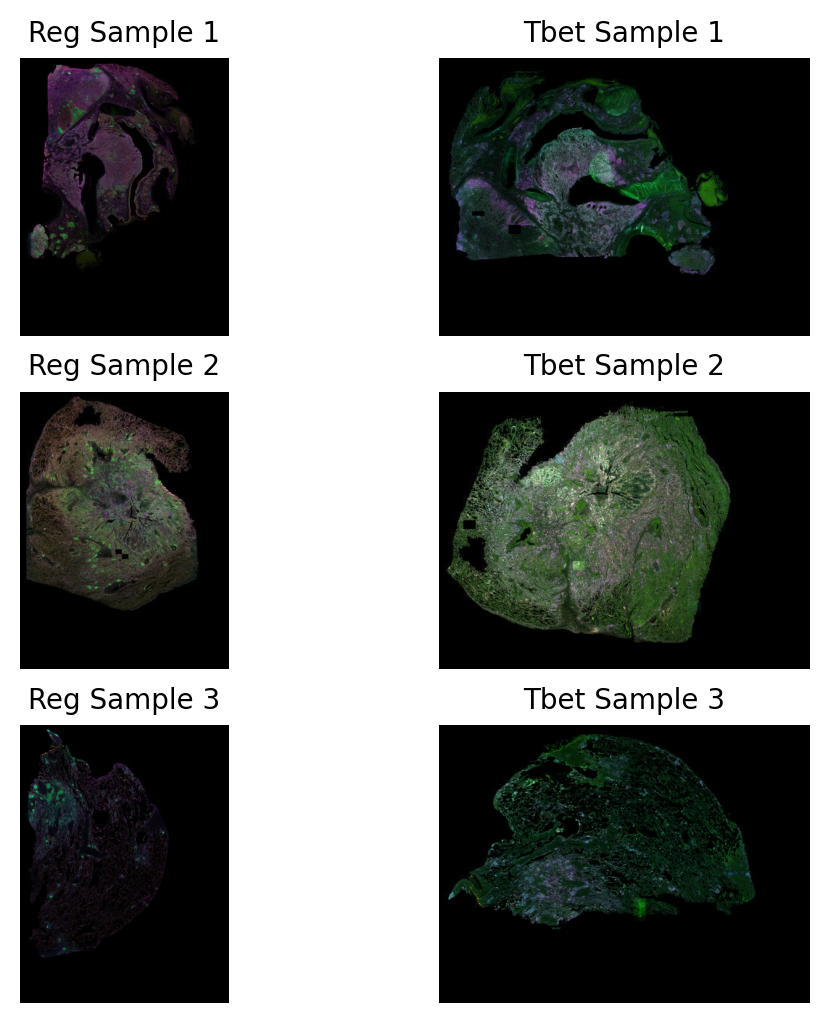

In [79]:
# Plot the images using sidus.pl

pl.SubPlots(
    pl.ShowImage(sdata=sp, sampleid=results[0]['reg_sampleid'], title="Reg Sample 1", cmap='gray'),  # reg_sampleid
    pl.ShowImage(sdata=sp, sampleid=results[0]['tbet_sampleid'], title="Tbet Sample 1"),  # tbet_sampleid

    pl.ShowImage(sdata=sp, sampleid=results[1]['reg_sampleid'], title="Reg Sample 2"),  # reg_sampleid
    pl.ShowImage(sdata=sp, sampleid=results[1]['tbet_sampleid'], title="Tbet Sample 2"),  # tbet_sampleid

    pl.ShowImage(sdata=sp, sampleid=results[2]['reg_sampleid'], title="Reg Sample 3"),  # reg_sampleid
    pl.ShowImage(sdata=sp, sampleid=results[2]['tbet_sampleid'], title="Tbet Sample 3"),  # tbet_sampleid

    figsize=(5, 5),
)

## Rigid Registration (Scale 9)

### Load in spatial data 

In [80]:
# Loop through each image in sp.images and crop it
cropped_images = {}
for sampleid in sp.images:
    cropped_images[sampleid] = tl.crop_xarray_image(sp.images[sampleid], scale=9)[0]

#Create a dataframe with a columnn named panel that loops either axis, regression and tbet 3 times

panel = ['regression','tbet']*3

panel_df = pd.DataFrame(panel, columns=['panel'])

#Create a dataframe with a columnn named panel that loops either axis, regression and tbet 3 times

panel = ['regression','tbet']*3

panel_df = pd.DataFrame(panel, columns=['panel'])


#Save dimensions of the cropped images to a dataframe


cropped_images_dimensions = {}
for sampleid, cropped_image in cropped_images.items():
    cropped_images_dimensions[sampleid] = {
        'dimensions': cropped_image.shape,
        'data_type': cropped_image.dtype,
        'coordinates': cropped_image.coords
    }
#Convert to dataframe
cropped_images_dimensions_df = pd.DataFrame.from_dict(cropped_images_dimensions, orient='index')

#Add the panel column to the dataframe

cropped_images_dimensions_df['panel'] = panel_df['panel'].values

#View dimensions of the cropped images
cropped_images_dimensions_df

,dimensions,data_type,coordinates,panel
sampleid_709_image,"(128, 96)",float32,"[c, y, x]",regression
sampleid_834_image,"(96, 128)",float32,"[c, y, x]",tbet
sampleid_710_image,"(128, 96)",float32,"[c, y, x]",regression
sampleid_835_image,"(96, 128)",float32,"[c, y, x]",tbet
sampleid_712_image,"(128, 96)",float32,"[c, y, x]",regression
sampleid_837_image,"(96, 128)",float32,"[c, y, x]",tbet


In [81]:
#Get all the keys in the cropped_images dictionary
reg_name_1 = list(cropped_images.keys())[0]
tbet_name_1 = list(cropped_images.keys())[1]

reg_name_2 = list(cropped_images.keys())[2]
tbet_name_2 = list(cropped_images.keys())[3]

reg_name_3 = list(cropped_images.keys())[4]
tbet_name_3 = list(cropped_images.keys())[5]

In [82]:
#Convert the cropped images to ants
reg_image_cropped_ants_1 = ants.from_numpy(cropped_images[f'sampleid_{results[0]["reg_sampleid"]}_image'].compute().data)
tbet_image_cropped_ants_1 = ants.from_numpy(cropped_images[f'sampleid_{results[0]["tbet_sampleid"]}_image'].compute().data)

reg_image_cropped_ants_2 = ants.from_numpy(cropped_images[f'sampleid_{results[1]["reg_sampleid"]}_image'].compute().data)
tbet_image_cropped_ants_2 = ants.from_numpy(cropped_images[f'sampleid_{results[1]["tbet_sampleid"]}_image'].compute().data)

reg_image_cropped_ants_3 = ants.from_numpy(cropped_images[f'sampleid_{results[2]["reg_sampleid"]}_image'].compute().data)
tbet_image_cropped_ants_3 = ants.from_numpy(cropped_images[f'sampleid_{results[2]["tbet_sampleid"]}_image'].compute().data)


### Pad images

In [83]:
#Pad the images so they are the same size
reg_image_cropped_shape_1 = reg_image_cropped_ants_1.shape
tbet_image_cropped_shape_1= tbet_image_cropped_ants_1.shape

reg_image_cropped_shape_2 = reg_image_cropped_ants_2.shape
tbet_image_cropped_shape_2= tbet_image_cropped_ants_2.shape

reg_image_cropped_shape_3 = reg_image_cropped_ants_3.shape
tbet_image_cropped_shape_3= tbet_image_cropped_ants_3.shape


#Get the target shapes for padding
target_shape_1_x = max(reg_image_cropped_shape_1[0],tbet_image_cropped_shape_1[0])
target_shape_1_y = max(reg_image_cropped_shape_1[1],tbet_image_cropped_shape_1[1])

target_shape_2_x = max(reg_image_cropped_shape_2[0],tbet_image_cropped_shape_2[0])
target_shape_2_y = max(reg_image_cropped_shape_2[1],tbet_image_cropped_shape_2[1])

target_shape_3_x = max(reg_image_cropped_shape_3[0],tbet_image_cropped_shape_3[0])
target_shape_3_y = max(reg_image_cropped_shape_3[1],tbet_image_cropped_shape_3[1])

#Calculate the padding
pad_reg_X_1 = (0,target_shape_1_x-reg_image_cropped_shape_1[0])
pad_reg_Y_1 = (0,target_shape_1_y-reg_image_cropped_shape_1[1])

pad_reg_X_2 = (0,target_shape_2_x-reg_image_cropped_shape_2[0])
pad_reg_Y_2 = (0,target_shape_2_y-reg_image_cropped_shape_2[1])

pad_reg_X_3 = (0,target_shape_3_x-reg_image_cropped_shape_3[0])
pad_reg_Y_3 = (0,target_shape_3_y-reg_image_cropped_shape_3[1])



# Pad the cropped images to match the size of the rigid transformed images
reg_image_cropped_ants_1_padded = ants.pad_image(reg_image_cropped_ants_1, (target_shape_1_x,target_shape_1_y))
reg_image_cropped_ants_2_padded = ants.pad_image(reg_image_cropped_ants_2, (target_shape_2_x,target_shape_2_y))
reg_image_cropped_ants_3_padded = ants.pad_image(reg_image_cropped_ants_3, (target_shape_3_x,target_shape_3_y))


# Pad the tbet images to match the size of the rigid transformed images
tbet_image_cropped_ants_1_padded = ants.pad_image(tbet_image_cropped_ants_1, (target_shape_1_x,target_shape_1_y))
tbet_image_cropped_ants_2_padded = ants.pad_image(tbet_image_cropped_ants_2, (target_shape_2_x,target_shape_2_y))
tbet_image_cropped_ants_3_padded = ants.pad_image(tbet_image_cropped_ants_3, (target_shape_3_x,target_shape_3_y))


# Print the shapes of the padded images
print("Padded regression image shape 1: ", reg_image_cropped_ants_1_padded.shape)
print("Padded regression image shape 2: ", reg_image_cropped_ants_2_padded.shape)
print("Padded regression image shape 3: ", reg_image_cropped_ants_3_padded.shape,"\n")


print("Padded tbet image shape 1: ", tbet_image_cropped_ants_1_padded.shape)
print("Padded tbet image shape 2: ", tbet_image_cropped_ants_2_padded.shape)
print("Padded tbet image shape 3: ", tbet_image_cropped_ants_3_padded.shape,"\n")



Padded regression image shape 1:  (128, 128)
Padded regression image shape 2:  (128, 128)
Padded regression image shape 3:  (128, 128) 

Padded tbet image shape 1:  (128, 128)
Padded tbet image shape 2:  (128, 128)
Padded tbet image shape 3:  (128, 128) 



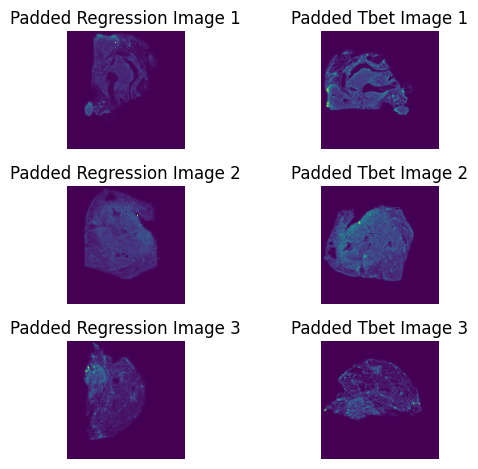

In [84]:
#Plot the padded images

plt.subplot(3, 2, 1)    
plt.imshow(reg_image_cropped_ants_1_padded.numpy())
plt.title('Padded Regression Image 1')
plt.axis('off')
plt.subplot(3, 2, 2)
plt.imshow(tbet_image_cropped_ants_1_padded.numpy())
plt.title('Padded Tbet Image 1')
plt.axis('off')
plt.subplot(3, 2, 3)
plt.imshow(reg_image_cropped_ants_2_padded.numpy())
plt.title('Padded Regression Image 2')
plt.axis('off')
plt.subplot(3, 2, 4)
plt.imshow(tbet_image_cropped_ants_2_padded.numpy())
plt.title('Padded Tbet Image 2')
plt.axis('off')
plt.subplot(3, 2, 5)
plt.imshow(reg_image_cropped_ants_3_padded.numpy())
plt.title('Padded Regression Image 3')
plt.axis('off')
plt.subplot(3, 2, 6)
plt.imshow(tbet_image_cropped_ants_3_padded.numpy())
plt.title('Padded Tbet Image 3')
plt.axis('off')
plt.tight_layout()
plt.show()

### ANTS Rigid transform 

In [85]:
# Perform rigid registration first on the first image
rigid_result_1 = ants.registration(
    fixed=reg_image_cropped_ants_1_padded,
    moving=tbet_image_cropped_ants_1_padded,
    type_of_transform='Rigid',
    verbose=True,
    outprefix='C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_rigid_registration_image1_'  # Descriptive outprefix
)

# Apply the rigid transformation to the first moving image
rigid_transformed_image_1 = ants.apply_transforms(
    fixed=reg_image_cropped_ants_1_padded,
    moving=tbet_image_cropped_ants_1_padded,
    transformlist=rigid_result_1['fwdtransforms']
)

# Perform rigid registration first on the second image
rigid_result_2 = ants.registration(
    fixed=reg_image_cropped_ants_2_padded,
    moving=tbet_image_cropped_ants_2_padded,
    type_of_transform='Rigid',
    verbose=True,
    outprefix='C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_rigid_registration_image2_'  # Descriptive outprefix
)

# Apply the rigid transformation to the second moving image
rigid_transformed_image_2 = ants.apply_transforms(
    fixed=reg_image_cropped_ants_2_padded,
    moving=tbet_image_cropped_ants_2_padded,
    transformlist=rigid_result_2['fwdtransforms']
)

# Perform rigid registration first on the third image
rigid_result_3 = ants.registration(
    fixed=reg_image_cropped_ants_3_padded,
    moving=tbet_image_cropped_ants_3_padded,
    type_of_transform='Rigid',
    verbose=True,
    outprefix='C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_rigid_registration_image3_'  # Descriptive outprefix
)

# Apply the rigid transformation to the third moving image
rigid_transformed_image_3 = ants.apply_transforms(
    fixed=reg_image_cropped_ants_3_padded,
    moving=tbet_image_cropped_ants_3_padded,
    transformlist=rigid_result_3['fwdtransforms']
)

antsRegistration -d 2 -r [000002538ED3A368,000002538ED3A388,1] -m mattes[000002538ED3A368,000002538ED3A388,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:\Users\molanre1\Desktop\WSIFIR\reg_tbet_rigid_registration_image1_,000002539456A728,0000025394569BC8] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r [000002538ED3A368,000002538ED3A388,1] -m mattes[000002538ED3A368,000002538ED3A388,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:\Users\molanre1\Desktop\WSIFIR\reg_tbet_rigid_registration_image2_,0000025394569BC8,00000253945695E8] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r [000002538ED3A368,000002538ED3A388,1] -m mattes[000002538ED3A368,000002538ED3A388,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:\Users\molanre1\Desktop\WSIFIR\reg_tbet_rigid_registration_image3_,00000253945695E8,000

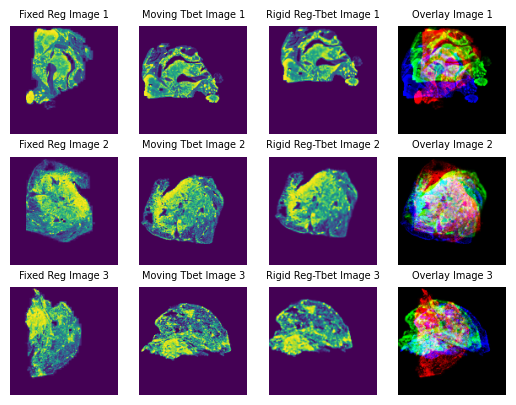

In [86]:
# Visualize the results
plt.subplot(3,4,1)
fixed_1 = exposure.equalize_hist(reg_image_cropped_ants_1_padded.numpy())
plt.imshow(fixed_1)
plt.title(f'Fixed Reg Image 1', fontsize=7)
plt.axis('off')

plt.subplot(3,4,2)
moving_1 = exposure.equalize_hist(tbet_image_cropped_ants_1_padded.numpy())
plt.imshow(moving_1)
plt.title(f'Moving Tbet Image 1', fontsize=7)
plt.axis('off')

plt.subplot(3,4,3)
registered_1 = exposure.equalize_hist(rigid_result_1['warpedmovout'].numpy())
plt.imshow(registered_1)
plt.title('Rigid Reg-Tbet Image 1', fontsize=7)
plt.axis('off')

# Normalize the images to [0, 1] for proper overlay visualization
fixed_1_normalized = (fixed_1 - fixed_1.min()) / (fixed_1.max() - fixed_1.min())
registered_1_normalized = (registered_1 - registered_1.min()) / (registered_1.max() - registered_1.min())
moving_1_normalized = (moving_1 - moving_1.min()) / (moving_1.max() - moving_1.min())


# Overlay for the first image
plt.subplot(3, 4, 4)
overlay_1 = np.stack([fixed_1_normalized, registered_1_normalized, moving_1_normalized], axis=-1)  # Red for fixed, Blue for moving. Green for registered
plt.imshow(overlay_1)
plt.title('Overlay Image 1', fontsize=7)
plt.axis('off')

plt.subplot(3,4,5)
fixed_2 = exposure.equalize_hist(reg_image_cropped_ants_2_padded.numpy())
plt.imshow(fixed_2)
plt.title(f'Fixed Reg Image 2', fontsize=7)
plt.axis('off')

plt.subplot(3,4,6)
moving_2 = exposure.equalize_hist(tbet_image_cropped_ants_2_padded.numpy())
plt.imshow(moving_2)
plt.title(f'Moving Tbet Image 2', fontsize=7)
plt.axis('off')

plt.subplot(3,4,7)
registered_2 = exposure.equalize_hist(rigid_result_2['warpedmovout'].numpy())
plt.imshow(registered_2)
plt.title('Rigid Reg-Tbet Image 2', fontsize=7)
plt.axis('off')

# Normalize the images to [0, 1] for proper overlay visualization
fixed_2_normalized = (fixed_2 - fixed_2.min()) / (fixed_2.max() - fixed_2.min())
registered_2_normalized = (registered_2 - registered_2.min()) / (registered_2.max() - registered_2.min())
moving_2_normalized = (moving_2 - moving_2.min()) / (moving_2.max() - moving_2.min())

# Overlay for the second image
plt.subplot(3, 4, 8)
overlay_2 = np.stack([fixed_2_normalized, registered_2_normalized, moving_2_normalized], axis=-1)  # Red for fixed, Blue for moving. Green for registered
plt.imshow(overlay_2)
plt.axis('off')
plt.title('Overlay Image 2', fontsize=7)

plt.subplot(3,4,9)
fixed_3 = exposure.equalize_hist(reg_image_cropped_ants_3_padded.numpy())
plt.imshow(fixed_3)
plt.title(f'Fixed Reg Image 3', fontsize=7)
plt.axis('off')
plt.subplot(3,4,10)
moving_3 = exposure.equalize_hist(tbet_image_cropped_ants_3_padded.numpy())
plt.imshow(moving_3)
plt.title(f'Moving Tbet Image 3', fontsize=7)
plt.axis('off')
plt.subplot(3,4,11)
registered_3 = exposure.equalize_hist(rigid_result_3['warpedmovout'].numpy())
plt.imshow(registered_3)
plt.title('Rigid Reg-Tbet Image 3', fontsize=7)
plt.axis('off')

# Normalize the images to [0, 1] for proper overlay visualization
fixed_3_normalized = (fixed_3 - fixed_3.min()) / (fixed_3.max() - fixed_3.min())
registered_3_normalized = (registered_3 - registered_3.min()) / (registered_3.max() - registered_3.min())
moving_3_normalized = (moving_3 - moving_3.min()) / (moving_3.max() - moving_3.min())


# Overlay for the third image
plt.subplot(3, 4, 12)
overlay_3 = np.stack([fixed_3_normalized, registered_3_normalized, moving_3_normalized], axis=-1)  # Red for fixed, Blue for moving. Green for registered
plt.imshow(overlay_3)
plt.title('Overlay Image 3', fontsize=7)
plt.axis('off')
plt.show()

In [87]:
#View image metadata
rigid_result_1 

{'warpedmovout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (128, 128)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, -16.0)
 	 Direction  : [1. 0. 0. 1.],
 'warpedfixout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (128, 128)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (-16.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'fwdtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_rigid_registration_image1_0GenericAffine.mat'],
 'invtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_rigid_registration_image1_0GenericAffine.mat']}

In [88]:
#Get transform parameters
fwd_aff_1 = ants.read_transform(rigid_result_1['fwdtransforms'][0])
fwd_aff_1_parameters_np = np.array(fwd_aff_1.parameters)
fwd_aff_1_parameters_np

array([ 0.99990338,  0.01390118, -0.01390118,  0.99990338,  3.24885869,
        5.25402832])

In [89]:
#View image metadata
rigid_result_2 

{'warpedmovout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (128, 128)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, -16.0)
 	 Direction  : [1. 0. 0. 1.],
 'warpedfixout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (128, 128)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (-16.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'fwdtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_rigid_registration_image2_0GenericAffine.mat'],
 'invtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_rigid_registration_image2_0GenericAffine.mat']}

In [90]:
#Get transform parameters
fwd_aff_2 = ants.read_transform(rigid_result_2['fwdtransforms'][0])
fwd_aff_2_parameters_np = np.array(fwd_aff_2.parameters)
fwd_aff_2_parameters_np

array([ 9.99987245e-01, -5.04803890e-03,  5.04803890e-03,  9.99987245e-01,
       -8.31407833e+00,  1.14363499e+01])

In [91]:
#View image metadata
rigid_result_3

{'warpedmovout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (128, 128)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, -16.0)
 	 Direction  : [1. 0. 0. 1.],
 'warpedfixout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (128, 128)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (-16.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'fwdtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_rigid_registration_image3_0GenericAffine.mat'],
 'invtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_rigid_registration_image3_0GenericAffine.mat']}

In [92]:
#Get transform parameters
fwd_aff_3 = ants.read_transform(rigid_result_3['fwdtransforms'][0])
fwd_aff_3_parameters_np = np.array(fwd_aff_3.parameters)
fwd_aff_3_parameters_np

array([ 9.99987781e-01,  4.94394638e-03, -4.94394638e-03,  9.99987781e-01,
       -1.15440044e+01,  2.63324757e+01])

### Metrics

In [93]:
#Compute mutual information between the fixed regression and  transformed axis-reg image 
mi1 = ants.image_mutual_information(reg_image_cropped_ants_1_padded,rigid_result_1['warpedmovout']) 
mi2 = ants.image_mutual_information(reg_image_cropped_ants_2_padded, rigid_result_2['warpedmovout'])   
mi3 = ants.image_mutual_information(reg_image_cropped_ants_3_padded, rigid_result_3['warpedmovout'])


#Compute normalized cross correlation between the fixed regression and  transformed axis-reg image 
cc1 = ants.math.image_similarity(reg_image_cropped_ants_1_padded,rigid_result_1['warpedmovout'], 'Correlation')
cc2 = ants.math.image_similarity(reg_image_cropped_ants_2_padded, rigid_result_2['warpedmovout'], 'Correlation')
cc3 = ants.math.image_similarity(reg_image_cropped_ants_3_padded, rigid_result_3['warpedmovout'], 'Correlation')

#Compute mean squares between the fixed regression and  transformed axis-reg image 
mse1 = ants.math.image_similarity(reg_image_cropped_ants_1_padded, rigid_result_1['warpedmovout'], 'MeanSquares')
mse2 = ants.math.image_similarity(reg_image_cropped_ants_2_padded, rigid_result_2['warpedmovout'], 'MeanSquares')
mse3 = ants.math.image_similarity(reg_image_cropped_ants_3_padded, rigid_result_3['warpedmovout'], 'MeanSquares')


In [94]:
# Binarize the arrays (threshold = 0.5)
reg_image_1_binary = (reg_image_cropped_ants_1_padded.numpy() > 0.5).astype(int)
reg_image_2_binary = (reg_image_cropped_ants_2_padded.numpy() > 0.5).astype(int)
reg_image_3_binary = (reg_image_cropped_ants_3_padded.numpy() > 0.5).astype(int)

rigid_result_1_binary = (rigid_result_1['warpedmovout'].numpy() > 0.5).astype(int)
rigid_result_2_binary = (rigid_result_2['warpedmovout'].numpy() > 0.5).astype(int)
rigid_result_3_binary = (rigid_result_3['warpedmovout'].numpy() > 0.5).astype(int)

In [95]:
# Compute Jaccard Index
jaccard_1 = jaccard_score(reg_image_1_binary.flatten(), rigid_result_1_binary.flatten())
jaccard_2 = jaccard_score(reg_image_2_binary.flatten(), rigid_result_2_binary.flatten())
jaccard_3 = jaccard_score(reg_image_3_binary.flatten(), rigid_result_3_binary.flatten())

# Compute Dice Similarity Score
dice1 = f1_score(reg_image_1_binary.flatten(), rigid_result_1_binary.flatten())
dice2 = f1_score(reg_image_2_binary.flatten(), rigid_result_2_binary.flatten())
dice3 = f1_score(reg_image_3_binary.flatten(), rigid_result_3_binary.flatten())


In [96]:
# Compute Hausdorff Distance using SimpleITK
sitk_initial_image_1 = sitk.GetImageFromArray(reg_image_cropped_ants_1_padded.numpy())
sitk_final_image_1 = sitk.GetImageFromArray(rigid_result_1['warpedmovout'].numpy())

sitk_initial_image_2 = sitk.GetImageFromArray(reg_image_cropped_ants_2_padded.numpy())
sitk_final_image_2 = sitk.GetImageFromArray(rigid_result_2['warpedmovout'].numpy())

sitk_initial_image_3 = sitk.GetImageFromArray(reg_image_cropped_ants_3_padded.numpy())
sitk_final_image_3 = sitk.GetImageFromArray(rigid_result_3['warpedmovout'].numpy())

# Compute Hausdorff Distance for axis image 1 and final image 1
hausdorff_filter_1 = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_1.Execute(sitk_initial_image_1, sitk_final_image_1)
hausdorff_sitk_1 = hausdorff_filter_1.GetHausdorffDistance()

#Compute Hausdorff Distance for axis image 2 and final image 2
hausdorff_filter_2 = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_2.Execute(sitk_initial_image_2, sitk_final_image_2)
hausdorff_sitk_2 = hausdorff_filter_2.GetHausdorffDistance()

#Compute Hausdorff Distance for axis image 3 and final image 3
hausdorff_filter_3 = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_3.Execute(sitk_initial_image_3, sitk_final_image_3)
hausdorff_sitk_3 = hausdorff_filter_3.GetHausdorffDistance()


<Figure size 1000x600 with 0 Axes>

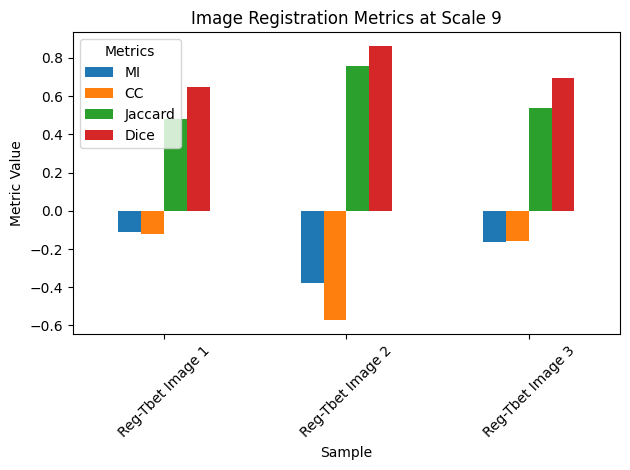

<Figure size 1000x600 with 0 Axes>

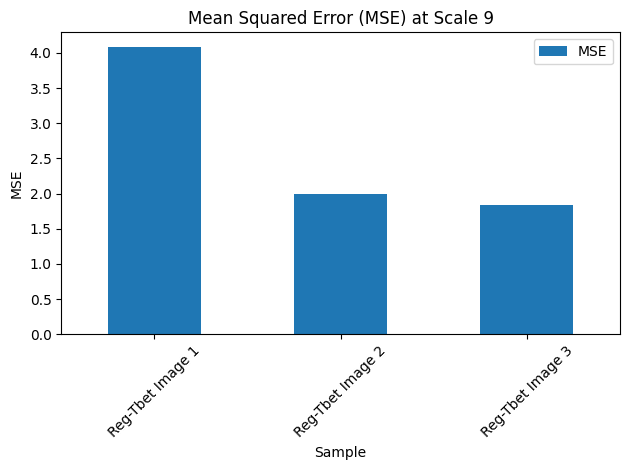

<Figure size 1000x600 with 0 Axes>

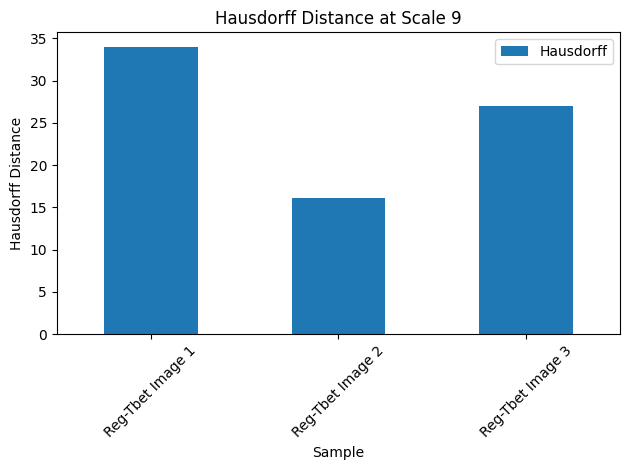

In [97]:
#Display the mi, cc, mse, jaccard, dice and hausdorff distance as graphs
metrics_df = pd.DataFrame({
    'Sample': ['Reg-Tbet Image 1', 'Reg-Tbet Image 2', 'Reg-Tbet Image 3'],
    'MI': [mi1, mi2, mi3],
    'CC': [cc1, cc2, cc3],
    'MSE': [mse1, mse2, mse3],
    'Jaccard': [jaccard_1, jaccard_2, jaccard_3],
    'Dice': [dice1, dice2, dice3],
    'Hausdorff': [hausdorff_sitk_1, hausdorff_sitk_2, hausdorff_sitk_3]
})

# Set the index to the Sample ID
metrics_df.set_index('Sample', inplace=True)

# Plot the metrics minus hausdorff distance and mse
plt.figure(figsize=(10, 6))
metrics_df[['MI', 'CC', 'Jaccard', 'Dice']].plot(kind='bar')
plt.title('Image Registration Metrics at Scale 9')
plt.ylabel('Metric Value')
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

# Plot the Mean Squared Error (MSE)
plt.figure(figsize=(10, 6))
metrics_df[['MSE']].plot(kind='bar')
plt.title('Mean Squared Error (MSE) at Scale 9')
plt.ylabel('MSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Plot the Hausdorff distance
plt.figure(figsize=(10, 6))
metrics_df[['Hausdorff']].plot(kind='bar')
plt.title('Hausdorff Distance at Scale 9')
plt.ylabel('Hausdorff Distance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [98]:
#Convert each set of corresponding tissue slices into a DataFrame
#Each row has the same tissue, but 3 different slices representing the same tissue stained with the axis, regression and tbet panels

#Each different row represents a different tissue
row_1 = ids.iloc[[0]].copy()
row_2 = ids.iloc[[1]].copy()
row_3 = ids.iloc[[2]].copy()
                              

# Concatenate the rows into a single DataFrame
merged_df = pd.concat([row_1, row_2, row_3], ignore_index=True)

#Add columns to the merged DataFrame
merged_df['scale'] = [9,9,9]    
merged_df['final_image_fixed_parameters'] = [fwd_aff_1.fixed_parameters,fwd_aff_2.fixed_parameters,fwd_aff_3.fixed_parameters] 
merged_df['final_image_parameters'] = [fwd_aff_1.parameters,fwd_aff_2.parameters,fwd_aff_3.parameters] 
merged_df['mi_reg_tbet_transformed'] = [mi1,mi2,mi3]
merged_df['cc_reg_tbet_transformed'] = [cc1,cc2,cc3]
merged_df['mse_reg_tbet_transformed'] = [mse1,mse2,mse3]
merged_df['jaccard_reg_tbet_transformed'] = [jaccard_1,jaccard_2,jaccard_3]
merged_df['dice_reg_tbet_transformed'] = [dice1,dice2,dice3]
merged_df['hausdorff_reg_tbet_transformed'] = [hausdorff_sitk_1,hausdorff_sitk_2,hausdorff_sitk_3]   

merged_df

,sampleid,reg_sampleid,tbet_sampleid,slideid,reg_slideid,tbet_slideid,scale,final_image_fixed_parameters,final_image_parameters,mi_reg_tbet_transformed,cc_reg_tbet_transformed,mse_reg_tbet_transformed,jaccard_reg_tbet_transformed,dice_reg_tbet_transformed,hausdorff_reg_tbet_transformed
0,101,709.0,834.0,L1_2,LY1,AP0140001,9,"[41.98567581176758, 35.215389251708984]","[0.9999033808708191, 0.013901183381676674, -0....",-0.109125,-0.123911,4.089284,0.482030,0.650500,34.000000
1,107,710.0,835.0,L2_4,LY2,AP0140002,9,"[52.78548049926758, 42.120697021484375]","[0.9999872446060181, -0.005048038903623819, 0....",-0.378557,-0.574085,1.988087,0.757860,0.862253,16.124515
2,535,712.0,837.0,L4_3,LY4,AP0140004,9,"[50.77205276489258, 28.47519302368164]","[0.999987781047821, 0.004943946376442909, -0.0...",-0.162886,-0.159307,1.842978,0.535438,0.697440,27.000000


In [99]:
#Save the merged DataFrame to a CSV file
merged_df.to_csv('C:/Users/molanre1/Desktop/WSIFIR/xform_reg_to_tbet_scale_9.csv', index=False)

## Rigid Regression (Scale 7)

### Load in spatial data

In [100]:
# Loop through each image in sp.images and crop it
cropped_images_2 = {}
for sampleid in sp.images:
    cropped_images_2[sampleid] = tl.crop_xarray_image(sp.images[sampleid], scale=7)[0]

#Create a dataframe with a columnn named panel that loops either axis, regression and tbet 3 times

panel_2 = ['regression','tbet']*3
panel_df_2 = pd.DataFrame(panel, columns=['panel'])

#Save dimensions of the cropped images to a dataframe
cropped_images_dimensions_2 = {}
for sampleid, cropped_image in cropped_images_2.items():
    cropped_images_dimensions_2[sampleid] = {
        'dimensions': cropped_image.shape,
        'data_type': cropped_image.dtype,
        'coordinates': cropped_image.coords,
    }


#Convert to dataframe
cropped_images_dimensions_df_2 = pd.DataFrame.from_dict(cropped_images_dimensions_2, orient='index')


#Add the panel column to the cropped images dimensions dataframe
cropped_images_dimensions_df_2['panel'] = panel_df_2['panel'].values

#View dimensions of the cropped images
cropped_images_dimensions_df_2

,dimensions,data_type,coordinates,panel
sampleid_709_image,"(512, 384)",float32,"[c, y, x]",regression
sampleid_834_image,"(384, 512)",float32,"[c, y, x]",tbet
sampleid_710_image,"(512, 384)",float32,"[c, y, x]",regression
sampleid_835_image,"(384, 512)",float32,"[c, y, x]",tbet
sampleid_712_image,"(512, 384)",float32,"[c, y, x]",regression
sampleid_837_image,"(384, 512)",float32,"[c, y, x]",tbet


In [127]:
#Convert the cropped images to ants
reg_image_cropped_ants_4 = ants.from_numpy(cropped_images_2[f'sampleid_{results[0]["reg_sampleid"]}_image'].compute().data)
tbet_image_cropped_ants_4 = ants.from_numpy(cropped_images_2[f'sampleid_{results[0]["tbet_sampleid"]}_image'].compute().data)

reg_image_cropped_ants_5 = ants.from_numpy(cropped_images_2[f'sampleid_{results[1]["reg_sampleid"]}_image'].compute().data)
tbet_image_cropped_ants_5 = ants.from_numpy(cropped_images_2[f'sampleid_{results[1]["tbet_sampleid"]}_image'].compute().data)

reg_image_cropped_ants_6 = ants.from_numpy(cropped_images_2[f'sampleid_{results[2]["reg_sampleid"]}_image'].compute().data)
tbet_image_cropped_ants_6 = ants.from_numpy(cropped_images_2[f'sampleid_{results[2]["tbet_sampleid"]}_image'].compute().data)


### Pad images

In [128]:
#Pad the images so they are the same size
reg_image_cropped_shape_4 = reg_image_cropped_ants_4.shape
tbet_image_cropped_shape_4= tbet_image_cropped_ants_4.shape

reg_image_cropped_shape_5 = reg_image_cropped_ants_5.shape
tbet_image_cropped_shape_5= tbet_image_cropped_ants_5.shape

reg_image_cropped_shape_6 = reg_image_cropped_ants_6.shape
tbet_image_cropped_shape_6= tbet_image_cropped_ants_6.shape

#Get the target shapes for padding
target_shape_4_x = max(reg_image_cropped_shape_4[0],tbet_image_cropped_shape_4[0])
target_shape_4_y = max(reg_image_cropped_shape_4[1],tbet_image_cropped_shape_4[1])

target_shape_5_x = max(reg_image_cropped_shape_5[0],tbet_image_cropped_shape_5[0])
target_shape_5_y = max(reg_image_cropped_shape_5[1],tbet_image_cropped_shape_5[1])

target_shape_6_x = max(reg_image_cropped_shape_6[0],tbet_image_cropped_shape_6[0])
target_shape_6_y = max(reg_image_cropped_shape_6[1],tbet_image_cropped_shape_6[1])


#Calculate the padding
pad_reg_X_4 = (0,target_shape_4_x-reg_image_cropped_shape_4[0])
pad_reg_Y_4 = (0,target_shape_4_y-reg_image_cropped_shape_4[1])
pad_reg_X_5 = (0,target_shape_5_x-reg_image_cropped_shape_5[0])
pad_reg_Y_5 = (0,target_shape_5_y-reg_image_cropped_shape_5[1])
pad_reg_X_6 = (0,target_shape_6_x-reg_image_cropped_shape_6[0])
pad_reg_Y_6 = (0,target_shape_6_y-reg_image_cropped_shape_6[1])

# Pad the cropped images to match the size of the rigid transformed images
reg_image_cropped_ants_4_padded = ants.pad_image(reg_image_cropped_ants_4, (target_shape_4_x,target_shape_4_y))
reg_image_cropped_ants_5_padded = ants.pad_image(reg_image_cropped_ants_5, (target_shape_5_x,target_shape_5_y))
reg_image_cropped_ants_6_padded = ants.pad_image(reg_image_cropped_ants_6, (target_shape_6_x,target_shape_6_y))

# Pad the tbet images to match the size of the rigid transformed images
tbet_image_cropped_ants_4_padded = ants.pad_image(tbet_image_cropped_ants_4, (target_shape_4_x,target_shape_4_y))
tbet_image_cropped_ants_5_padded = ants.pad_image(tbet_image_cropped_ants_5, (target_shape_5_x,target_shape_5_y))
tbet_image_cropped_ants_6_padded = ants.pad_image(tbet_image_cropped_ants_6, (target_shape_6_x,target_shape_6_y))


# Print the shapes of the padded images
print("Padded regression image shape 4: ", reg_image_cropped_ants_4_padded.shape)
print("Padded regression image shape 5: ", reg_image_cropped_ants_5_padded.shape)
print("Padded regression image shape 6: ", reg_image_cropped_ants_6_padded.shape,"\n")

print("Padded tbet image shape 4: ", tbet_image_cropped_ants_4_padded.shape)
print("Padded tbet image shape 5: ", tbet_image_cropped_ants_5_padded.shape)
print("Padded tbet image shape 6: ", tbet_image_cropped_ants_6_padded.shape,"\n")

Padded regression image shape 4:  (512, 512)
Padded regression image shape 5:  (512, 512)
Padded regression image shape 6:  (512, 512) 

Padded tbet image shape 4:  (512, 512)
Padded tbet image shape 5:  (512, 512)
Padded tbet image shape 6:  (512, 512) 



### Scale and apply registration parameters at lower resolution to higher resolution image

In [179]:

def compute_scaling_factor(higher_res_scale, lower_res_scale):
    """
    Compute the scaling factor based on the image transformations.
    """
    # Directly compute the scaling factor as a scalar
    return lower_res_scale / higher_res_scale
 
def scale_transform(transform_path, scaling_factors):
    """
    Scale a transformation matrix while preserving rotation components.
    
    Parameters:
        transform_path (str): Path to the original transformation matrix (.mat file).
        scaling_factors (list or float): Scaling factors for translation components. 
                                         Can be a scalar or a list of 3 values for 3D transformations.
    
    Returns:
        str: Path to the scaled transformation matrix.
    """
    try:
        # Read the transformation matrix
        transform = ants.read_transform(transform_path)
        
        # Extract the transformation parameters
        parameters = np.array(transform.parameters)  # Convert to a NumPy array for easier manipulation
        
        # Validate scaling_factors
        if isinstance(scaling_factors, (int, float)):  # If scalar, apply uniformly
            scaling_factors = [scaling_factors] * 3
        elif len(scaling_factors) != 3:
            raise ValueError("Scaling factors must be a scalar or a list of 3 values for 3D transformations.")
        
        # Scale only the translation components (first three parameters for tx, ty, tz)
        scaled_parameters = parameters.copy()
        if len(parameters) >= 3:  # Ensure there are at least 3 parameters
            scaled_parameters[:3] *= scaling_factors  # Scale translation components (tx, ty, tz)
        else:
            raise ValueError("Transformation parameters do not have enough components to scale translation.")
        
        # Create a new transform with the scaled parameters
        scaled_transform = ants.create_ants_transform(
            transform_type=transform.type,  # Use the same transform type
            dimension=transform.dimension,  # Use the same dimension
            parameters=scaled_parameters.tolist(),  # Convert back to a list
            fixed_parameters=transform.fixed_parameters  # Keep the fixed parameters unchanged
        )
        
        # Save the scaled transformation matrix
        scaled_transform_path = transform_path.replace('.mat', '_scaled.mat')
        ants.write_transform(scaled_transform, scaled_transform_path)
        
        return scaled_transform_path
    
    except Exception as e:
        raise RuntimeError(f"Error scaling transform: {e}")

# Compute scaling factor and adjust transformations for each image
low_res_image_1 = reg_image_cropped_ants_1_padded  # Low-resolution image
high_res_image_1 = reg_image_cropped_ants_4_padded  # High-resolution image

low_res_image_2 = reg_image_cropped_ants_2_padded  # Low-resolution image
high_res_image_2 = reg_image_cropped_ants_5_padded  # High-resolution image

low_res_image_3 = reg_image_cropped_ants_3_padded  # Low-resolution image
high_res_image_3 = reg_image_cropped_ants_6_padded  # High-resolution image


# Compute scaling factors for scale 7 and scale 9
scaling_factor_1 = compute_scaling_factor(sp.images[f'{reg_name_1}']['scale7'].image.transform['scale0'].scale[0], sp.images[f'{reg_name_1}']['scale9'].image.transform['scale0'].scale[0])
scaling_factor_2 = compute_scaling_factor(sp.images[f'{reg_name_2}']['scale7'].image.transform['scale0'].scale[0], sp.images[f'{reg_name_2}']['scale9'].image.transform['scale0'].scale[0])
scaling_factor_3 = compute_scaling_factor(sp.images[f'{reg_name_3}']['scale7'].image.transform['scale0'].scale[0], sp.images[f'{reg_name_3}']['scale9'].image.transform['scale0'].scale[0])

#Convert the scaling factors to be floats
scaling_factor_1 = float(scaling_factor_1)
scaling_factor_2 = float(scaling_factor_2)
scaling_factor_3 = float(scaling_factor_3)

### ANTS Rigid transform

In [73]:
# Apply the scaling factors to the transformations
scaled_transform_4 = scale_transform(
    'C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_rigid_registration_image1_0GenericAffine.mat',
    scaling_factor_1
)
# Apply the scaled transformation to the first image
rigid_transformed_image_4 = ants.apply_transforms(
    fixed=reg_image_cropped_ants_4_padded,
    moving=tbet_image_cropped_ants_4_padded,
    transformlist=scaled_transform_4
)
# Perform rigid registration first on the first image
rigid_result_4 = ants.registration(
    fixed=rigid_transformed_image_4, #rigid_transformed_image_4 should be moving
    moving=tbet_image_cropped_ants_4_padded, #regression should be fixed
    type_of_transform='Rigid',
    verbose=True,
    outprefix='C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_rigid_registration_image4_'
)

# Apply the scaling factors to the transformations
scaled_transform_5 = scale_transform(
    'C:\\Users\\molanre1\\Desktop\\WSIFIR\\rigid_registration_image2_0GenericAffine.mat',
    scaling_factor_2
)
# Apply the scaled transformation to the second image
rigid_transformed_image_5 = ants.apply_transforms(
    fixed=reg_image_cropped_ants_5_padded,
    moving=tbet_image_cropped_ants_5_padded,
    transformlist=scaled_transform_5
)
# Perform rigid registration first on the second image
rigid_result_5 = ants.registration(
    fixed=rigid_transformed_image_5,
    moving=tbet_image_cropped_ants_5_padded,
    type_of_transform='Rigid',
    verbose=True,
    outprefix='C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_rigid_registration_image5_'

)
# Apply the scaling factors to the transformations
scaled_transform_6 = scale_transform(
    'C:\\Users\\molanre1\\Desktop\\WSIFIR\\rigid_registration_image3_0GenericAffine.mat',
    scaling_factor_3
)
# Apply the scaled transformation to the third image
rigid_transformed_image_6 = ants.apply_transforms(
    fixed=reg_image_cropped_ants_6_padded,
    moving=tbet_image_cropped_ants_6_padded,
    transformlist=scaled_transform_6
)
# Perform rigid registration first on the third image

rigid_result_6 = ants.registration(
    fixed=rigid_transformed_image_6,
    moving=tbet_image_cropped_ants_6_padded,
    type_of_transform='Rigid',
    verbose=True,
    outprefix='C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_rigid_registration_image6_'
)

antsRegistration -d 2 -r [0000021314B3B448,0000021314B3BC88,1] -m mattes[0000021314B3B448,0000021314B3BC88,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:\Users\molanre1\Desktop\WSIFIR\reg_tbet_rigid_registration_image4_,0000021314B38248,0000021314B3B388] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r [0000021314B3AF88,0000021314B3B388,1] -m mattes[0000021314B3AF88,0000021314B3B388,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:\Users\molanre1\Desktop\WSIFIR\reg_tbet_rigid_registration_image5_,0000021314B381A8,0000021314B3B448] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r [0000021314B3B448,0000021314B3BA08,1] -m mattes[0000021314B3B448,0000021314B3BA08,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:\Users\molanre1\Desktop\WSIFIR\reg_tbet_rigid_registration_image6_,000002131015C188,000

In [ ]:

def compute_scaling_factor(higher_res_scale, lower_res_scale):
    """
    Compute the scaling factor based on the image transformations.
    """
    # Directly compute the scaling factor as a scalar
    return lower_res_scale / higher_res_scale
 
def scale_transform(transform_path, scaling_factors):
    """
    Scale a transformation matrix while preserving rotation components.
    
    Parameters:
        transform_path (str): Path to the original transformation matrix (.mat file).
        scaling_factors (list or float): Scaling factors for translation components. 
                                         Can be a scalar or a list of 3 values for 3D transformations.
    
    Returns:
        str: Path to the scaled transformation matrix.
    """
    try:
        # Read the transformation matrix
        transform = ants.read_transform(transform_path)
        
        # Extract the transformation parameters
        parameters = np.array(transform.parameters)  # Convert to a NumPy array for easier manipulation
        
        # Validate scaling_factors
        if isinstance(scaling_factors, (int, float)):  # If scalar, apply uniformly
            scaling_factors = [scaling_factors] * 3
        elif len(scaling_factors) != 3:
            raise ValueError("Scaling factors must be a scalar or a list of 3 values for 3D transformations.")
        
        # Scale only the translation components (first three parameters for tx, ty, tz)
        scaled_parameters = parameters.copy()
        if len(parameters) >= 3:  # Ensure there are at least 3 parameters
            scaled_parameters[:3] *= scaling_factors  # Scale translation components (tx, ty, tz)
        else:
            raise ValueError("Transformation parameters do not have enough components to scale translation.")
        
        # Create a new transform with the scaled parameters
        scaled_transform = ants.create_ants_transform(
            transform_type=transform.type,  # Use the same transform type
            dimension=transform.dimension,  # Use the same dimension
            parameters=scaled_parameters.tolist(),  # Convert back to a list
            fixed_parameters=transform.fixed_parameters  # Keep the fixed parameters unchanged
        )
        
        # Save the scaled transformation matrix
        scaled_transform_path = transform_path.replace('.mat', '_scaled.mat')
        ants.write_transform(scaled_transform, scaled_transform_path)
        
        return scaled_transform_path
    
    except Exception as e:
        raise RuntimeError(f"Error scaling transform: {e}")

# Compute scaling factor and adjust transformations for each image
low_res_image_1 = reg_image_cropped_ants_1_padded  # Low-resolution image
high_res_image_1 = reg_image_cropped_ants_4_padded  # High-resolution image

low_res_image_2 = reg_image_cropped_ants_2_padded  # Low-resolution image
high_res_image_2 = reg_image_cropped_ants_5_padded  # High-resolution image

low_res_image_3 = reg_image_cropped_ants_3_padded  # Low-resolution image
high_res_image_3 = reg_image_cropped_ants_6_padded  # High-resolution image


# Compute scaling factors for scale 7 and scale 9
scaling_factor_1 = compute_scaling_factor(sp.images[f'{reg_name_1}']['scale7'].image.transform['scale0'].scale[0], sp.images[f'{reg_name_1}']['scale9'].image.transform['scale0'].scale[0])
scaling_factor_2 = compute_scaling_factor(sp.images[f'{reg_name_2}']['scale7'].image.transform['scale0'].scale[0], sp.images[f'{reg_name_2}']['scale9'].image.transform['scale0'].scale[0])
scaling_factor_3 = compute_scaling_factor(sp.images[f'{reg_name_3}']['scale7'].image.transform['scale0'].scale[0], sp.images[f'{reg_name_3}']['scale9'].image.transform['scale0'].scale[0])

#Convert the scaling factors to be floats
scaling_factor_1 = float(scaling_factor_1)
scaling_factor_2 = float(scaling_factor_2)
scaling_factor_3 = float(scaling_factor_3)

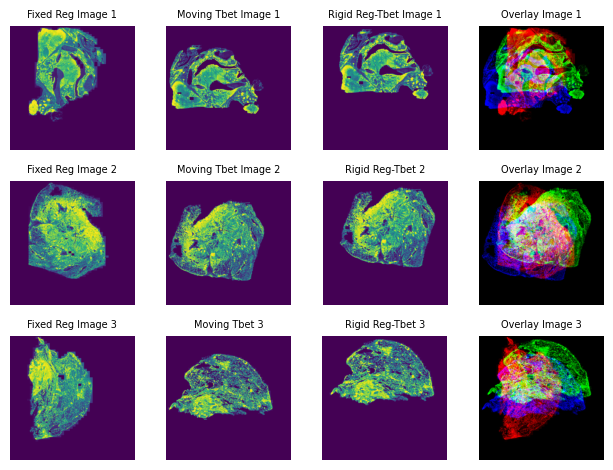

In [129]:
# Visualize the results
plt.subplot(3,4,1)
fixed_4 = exposure.equalize_hist(reg_image_cropped_ants_4_padded.numpy())
plt.imshow(fixed_4)
plt.title('Fixed Reg Image 1',fontsize=7)
plt.axis('off')

plt.subplot(3,4,2)
moving_4 = exposure.equalize_hist(tbet_image_cropped_ants_4_padded.numpy())
plt.imshow(moving_4) 
plt.title('Moving Tbet Image 1',fontsize=7)
plt.axis('off')

plt.subplot(3,4,3)
registered_4 = exposure.equalize_hist(rigid_result_4['warpedmovout'].numpy())
plt.imshow(registered_4)
plt.title('Rigid Reg-Tbet Image 1',fontsize=7)
plt.axis('off')

# Normalize the images to [0, 1] for proper overlay visualization
fixed_4_normalized = (fixed_4 - fixed_4.min()) / (fixed_4.max() - fixed_4.min())
registered_4_normalized = (registered_4 - registered_4.min()) / (registered_4.max() - registered_4.min())
moving_4_normalized = (moving_4 - moving_4.min()) / (moving_4.max() - moving_4.min())

#Overlay for the first image
plt.subplot(3, 4, 4)
overlay_4 = np.stack([fixed_4_normalized, registered_4_normalized, moving_4_normalized], axis=-1)  # Red for fixed, Blue for moving. Green for registered
plt.imshow(overlay_4)
plt.title('Overlay Image 1', fontsize=7)
plt.axis('off')

plt.subplot(3,4,5)
fixed_5 = exposure.equalize_hist(reg_image_cropped_ants_5_padded.numpy())
plt.imshow(fixed_5)
plt.title('Fixed Reg Image 2',fontsize=7)
plt.axis('off')

plt.subplot(3,4,6)
moving_5 = exposure.equalize_hist(tbet_image_cropped_ants_5_padded.numpy())
plt.imshow(moving_5)
plt.title('Moving Tbet Image 2', fontsize=7)
plt.axis('off')

plt.subplot(3,4,7)
registered_5 = exposure.equalize_hist(rigid_result_5['warpedmovout'].numpy())
plt.imshow(registered_5)
plt.title('Rigid Reg-Tbet 2',fontsize=7)
plt.axis('off')

# Normalize the images to [0, 1] for proper overlay visualization
fixed_5_normalized = (fixed_5 - fixed_5.min()) / (fixed_5.max() - fixed_5.min())
registered_5_normalized = (registered_5 - registered_5.min()) / (registered_5.max() - registered_5.min())
moving_5_normalized = (moving_5 - moving_5.min()) / (moving_5.max() - moving_5.min())

#Overlay for the second image
plt.subplot(3, 4, 8)
overlay_5 = np.stack([fixed_5_normalized, registered_5_normalized, moving_5_normalized], axis=-1)  # Red for fixed, Blue for moving. Green for registered
plt.imshow(overlay_5)
plt.title('Overlay Image 2', fontsize=7)
plt.axis('off')

plt.subplot(3,4,9)
fixed_6 = exposure.equalize_hist(reg_image_cropped_ants_6_padded.numpy())
plt.imshow(fixed_6) 
plt.title('Fixed Reg Image 3',fontsize=7)
plt.axis('off')

plt.subplot(3,4,10)
moving_6 = exposure.equalize_hist(tbet_image_cropped_ants_6_padded.numpy())
plt.imshow(moving_6)
plt.title('Moving Tbet 3',fontsize=7)
plt.axis('off')

plt.subplot(3,4,11)
registered_6 = exposure.equalize_hist(rigid_result_6['warpedmovout'].numpy())
plt.imshow(registered_6)
plt.title('Rigid Reg-Tbet 3',fontsize=7)
plt.axis('off')


# Normalize the images to [0, 1] for proper overlay visualization
fixed_6_normalized = (fixed_6 - fixed_6.min()) / (fixed_6.max() - fixed_6.min())
registered_6_normalized = (registered_6 - registered_6.min()) / (registered_6.max() - registered_6.min())
moving_6_normalized = (moving_6 - moving_6.min()) / (moving_6.max() - moving_6.min())

#Overlay for the third image
plt.subplot(3,4,12)
overlay_6 = np.stack([fixed_6_normalized, registered_6_normalized, moving_6_normalized], axis=-1)  # Red for fixed, Blue for moving. Green for registered
plt.imshow(overlay_6)
plt.title('Overlay Image 3', fontsize=7)
plt.axis('off')

plt.tight_layout()  
plt.show()


In [119]:
#View image metadata
rigid_result_4

{'warpedmovout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, -64.0)
 	 Direction  : [1. 0. 0. 1.],
 'warpedfixout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (-64.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'fwdtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_rigid_registration_image4_0GenericAffine.mat'],
 'invtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_rigid_registration_image4_0GenericAffine.mat']}

In [114]:
#Get transform parameters
fwd_aff_4 = ants.read_transform(rigid_result_4['fwdtransforms'][0])
fwd_aff_4_parameters_np = np.array(fwd_aff_4.parameters)
fwd_aff_4_parameters_np

array([ 0.99986309, -0.01654751,  0.01654751,  0.99986309, -0.7221005 ,
       11.84413147])

In [120]:
#View image metadata
rigid_result_5

{'warpedmovout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, -64.0)
 	 Direction  : [1. 0. 0. 1.],
 'warpedfixout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (-64.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'fwdtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_rigid_registration_image5_0GenericAffine.mat'],
 'invtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_rigid_registration_image5_0GenericAffine.mat']}

In [103]:
fwd_aff_5 = ants.read_transform(rigid_result_5['fwdtransforms'][0])
fwd_aff_5_parameters_np = np.array(fwd_aff_5.parameters)
fwd_aff_5_parameters_np

array([ 9.99992549e-01,  3.86586087e-03, -3.86586087e-03,  9.99992549e-01,
       -9.65142632e+00,  6.72973633e+00])

In [121]:
#View image metadata
rigid_result_6

{'warpedmovout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, -64.0)
 	 Direction  : [1. 0. 0. 1.],
 'warpedfixout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (-64.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'fwdtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_rigid_registration_image6_0GenericAffine.mat'],
 'invtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_rigid_registration_image6_0GenericAffine.mat']}

In [105]:
fwd_aff_6 = ants.read_transform(rigid_result_6['fwdtransforms'][0])
fwd_aff_6_parameters_np = np.array(fwd_aff_6.parameters)
fwd_aff_6_parameters_np

array([ 9.99936879e-01, -1.12379687e-02,  1.12379687e-02,  9.99936879e-01,
       -4.91876125e+00,  4.05891266e+01])

### Metrics

In [122]:
# Compute mutual information
mi4 = ants.image_mutual_information(rigid_transformed_image_4, rigid_result_4['warpedmovout'])
mi5 = ants.image_mutual_information(rigid_transformed_image_5, rigid_result_5['warpedmovout'])
mi6 = ants.image_mutual_information(rigid_transformed_image_6, rigid_result_6['warpedmovout'])

# Compute normalized cross-correlation
cc4 = ants.math.image_similarity(rigid_transformed_image_4,  rigid_result_4['warpedmovout'], 'Correlation')
cc5 = ants.math.image_similarity(rigid_transformed_image_5, rigid_result_5['warpedmovout'], 'Correlation')
cc6 = ants.math.image_similarity(rigid_transformed_image_6,  rigid_result_6['warpedmovout'], 'Correlation')

# Compute mean squares
mse4 = ants.math.image_similarity(rigid_transformed_image_4,  rigid_result_4['warpedmovout'], 'MeanSquares')
mse5 = ants.math.image_similarity(rigid_transformed_image_5,  rigid_result_5['warpedmovout'], 'MeanSquares')
mse6 = ants.math.image_similarity(rigid_transformed_image_6, rigid_result_6['warpedmovout'], 'MeanSquares')


In [ ]:
# Binarize the arrays (threshold = 0.5)
rigid_transformed_image_4_binary = (rigid_transformed_image_4.numpy() > 0.5).astype(int)
rigid_transformed_image_5_binary = (rigid_transformed_image_5.numpy() > 0.5).astype(int)
rigid_transformed_image_6_binary = (rigid_transformed_image_6.numpy() > 0.5).astype(int)

rigid_result_4_binary = (rigid_result_4['warpedmovout'].numpy() > 0.5).astype(int)
rigid_result_5_binary = (rigid_result_5['warpedmovout'].numpy() > 0.5).astype(int)
rigid_result_6_binary = (rigid_result_6['warpedmovout'].numpy() > 0.5).astype(int)

In [ ]:
# Compute Jaccard Index
jaccard_4 = jaccard_score(rigid_transformed_image_4_binary.flatten(), rigid_result_4_binary.flatten()) #Compare fixed (regression) to the new registred image. Want to see if the result is better at each register.Initial registeration pre and post registration
jaccard_5 = jaccard_score(rigid_transformed_image_5_binary.flatten(), rigid_result_5_binary.flatten())  
jaccard_6 = jaccard_score(rigid_transformed_image_6_binary.flatten(), rigid_result_6_binary.flatten())


# Compute Dice Similarity Score
dice4 = f1_score(rigid_transformed_image_4_binary.flatten(), rigid_result_4_binary.flatten())
dice5 = f1_score(rigid_transformed_image_5_binary.flatten(), rigid_result_5_binary.flatten())
dice6 = f1_score(rigid_transformed_image_6_binary.flatten(), rigid_result_6_binary.flatten())

In [126]:
# Compute Hausdorff Distance using SimpleITK
sitk_initial_image_4 = sitk.GetImageFromArray(rigid_transformed_image_4.numpy())
sitk_final_image_4 = sitk.GetImageFromArray(rigid_result_4['warpedmovout'].numpy())

sitk_initial_image_5 = sitk.GetImageFromArray(rigid_transformed_image_5.numpy())
sitk_final_image_5 = sitk.GetImageFromArray(rigid_result_5['warpedmovout'].numpy())

sitk_initial_image_6 = sitk.GetImageFromArray(rigid_transformed_image_6.numpy())
sitk_final_image_6 = sitk.GetImageFromArray(rigid_result_6['warpedmovout'].numpy())

# Compute Hausdorff Distance for axis image 1 and final image 1
hausdorff_filter_4 = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_4.Execute(sitk_initial_image_4, sitk_final_image_4)
hausdorff_sitk_4 = hausdorff_filter_4.GetHausdorffDistance()

hausdorff_filter_5 = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_5.Execute(sitk_initial_image_5, sitk_final_image_5)
hausdorff_sitk_5 = hausdorff_filter_5.GetHausdorffDistance()

hausdorff_filter_6 = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_6.Execute(sitk_initial_image_6, sitk_final_image_6)
hausdorff_sitk_6 = hausdorff_filter_6.GetHausdorffDistance()



<Figure size 1000x600 with 0 Axes>

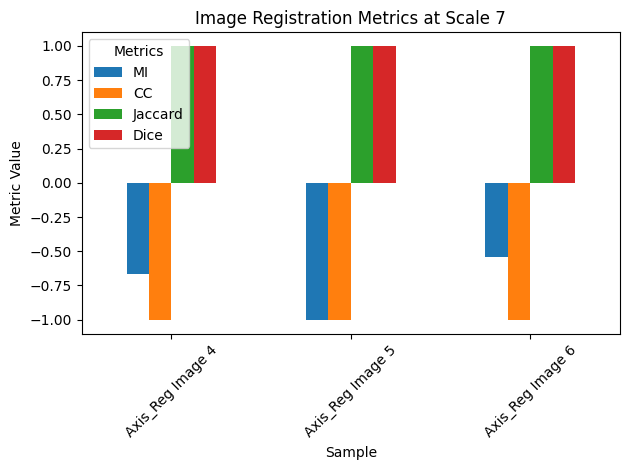

<Figure size 1000x600 with 0 Axes>

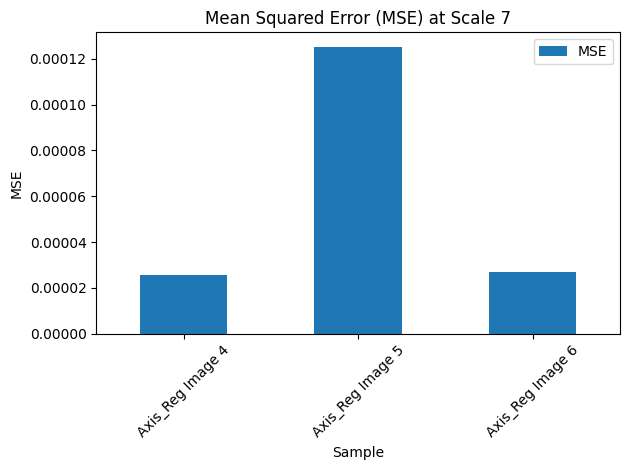

<Figure size 1000x600 with 0 Axes>

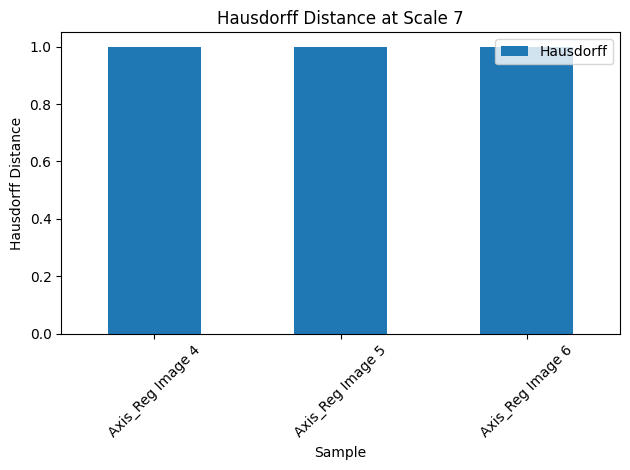

In [297]:
#Display the mi, cc, mse, jaccard, dice and hausdorff distance as graphs
metrics_df_1 = pd.DataFrame({
    'Sample': ['Axis_Reg Image 4', 'Axis_Reg Image 5', 'Axis_Reg Image 6'],
    'MI': [mi4, mi5, mi6],
    'CC': [cc4, cc5, cc6],
    'MSE': [mse4, mse5, mse6],
    'Jaccard': [jaccard_4, jaccard_5, jaccard_6],
    'Dice': [dice4, dice5, dice6],
    'Hausdorff': [hausdorff_sitk_4, hausdorff_sitk_5, hausdorff_sitk_6]
})

# Set the index to the Sample ID
metrics_df_1.set_index('Sample', inplace=True)

# Plot the metrics minus hausdorff distance and mse
plt.figure(figsize=(10, 6))
metrics_df_1[['MI', 'CC', 'Jaccard', 'Dice']].plot(kind='bar')
plt.title('Image Registration Metrics at Scale 7')
plt.ylabel('Metric Value')
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

# Plot the Mean Squared Error (MSE)
plt.figure(figsize=(10, 6))
metrics_df_1[['MSE']].plot(kind='bar')
plt.title('Mean Squared Error (MSE) at Scale 7')
plt.ylabel('MSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Plot the Hausdorff distance
plt.figure(figsize=(10, 6))
metrics_df_1[['Hausdorff']].plot(kind='bar')
plt.title('Hausdorff Distance at Scale 7')
plt.ylabel('Hausdorff Distance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [317]:
# Convert each set of corresponding tissue slices into a DataFrame
#Each row has the same tissue, but 3 different slices representing the same tissue stained with the axis, regression and tbet panels
#Each different row represents a different tissue

# Concatenate the rows into a single DataFrame
merged_df_2 = pd.concat([row_1, row_2, row_3], ignore_index=True)

#Add columns to the merged DataFrame
merged_df_2['scale'] = [7,7,7]
merged_df_2['final_image_fixed_parameters'] = [fwd_aff_4.fixed_parameters,fwd_aff_5.fixed_parameters,fwd_aff_6.fixed_parameters] 
merged_df_2['final_image_parameters'] = [fwd_aff_4.parameters,fwd_aff_5.parameters,fwd_aff_6.parameters] 
merged_df_2['mi_reg_tbet_transformed'] = [mi4,mi5,mi6]
merged_df_2['cc_reg_tbet_transformed'] = [cc4,cc5,cc6]
merged_df_2['mse_tbet_transformed'] = [mse4,mse5,mse6]
merged_df_2['jaccard_reg_tbet_transformed'] = [jaccard_4,jaccard_5,jaccard_6]
merged_df_2['dice_reg_tbet_transformed'] = [dice4,dice5,dice6]
merged_df_2['hausdorff_reg_tbet_transformed'] = [hausdorff_sitk_4,hausdorff_sitk_5,hausdorff_sitk_6]

merged_df_2

,sampleid,reg_sampleid,tbet_sampleid,slideid,reg_slideid,tbet_slideid,scale,final_image_fixed_parameters,final_image_parameters,mi_reg_tbet_transformed,cc_reg_tbet_transformed,mse_tbet_transformed,jaccard_reg_tbet_transformed,dice_reg_tbet_transformed,hausdorff_reg_tbet_transformed
0,101,709.0,834.0,L1_2,LY1,AP0140001,7,"[174.8902587890625, 168.3602294921875]","[0.9998630881309509, -0.016547514125704765, 0....",-0.669659,-0.999995,0.000026,0.999583,0.999791,1.0
1,107,710.0,835.0,L2_4,LY2,AP0140002,7,"[188.212158203125, 203.15960693359375]","[0.9999925494194031, 0.0038658608682453632, -0...",-1.001409,-0.999968,0.000125,0.999202,0.999601,1.0
2,535,712.0,837.0,L4_3,LY4,AP0140004,7,"[172.20706176757812, 181.14254760742188]","[0.9999368786811829, -0.011237968690693378, 0....",-0.544803,-0.999991,0.000027,0.999225,0.999612,1.0


In [318]:
#Save the merged DataFrame to a CSV file
merged_df_2.to_csv('C:/Users/molanre1/Desktop/WSIFIR/xform_reg_to_tbet_scale_7.csv', index=False)

## Affine Regression (Scale 5)

### Load in spatial data

In [227]:
#Loop through each image in sp.images and crop it
cropped_images_3 = {}
for sampleid in sp.images:
    cropped_images_3[sampleid] = tl.crop_xarray_image(sp.images[sampleid], scale=5)[0]


#Create a dataframe with a columnn named panel that loops either axis, regression and tbet 3 times
panel_3 = ['regression','tbet']*3
panel_df_3 = pd.DataFrame(panel, columns=['panel'])

#Save dimensions of the cropped images to a dataframw
cropped_images_dimensions_3 = {}
for sampleid, cropped_image in cropped_images_3.items():
    cropped_images_dimensions_3[sampleid] = {
        'dimensions': cropped_image.shape,
        'data_type': cropped_image.dtype,
        'coordinates': cropped_image.coords,
    }


#Convert to dataframe
cropped_images_dimensions_df_3 = pd.DataFrame.from_dict(cropped_images_dimensions_3, orient='index')


#Add the panel column to the cropped images dimensions dataframe
cropped_images_dimensions_df_3['panel'] = panel_df_3['panel'].values

#View dimensions of the cropped images
cropped_images_dimensions_df_3


,dimensions,data_type,coordinates,panel
sampleid_709_image,"(2048, 1536)",float32,"[c, y, x]",regression
sampleid_834_image,"(1536, 2048)",float32,"[c, y, x]",tbet
sampleid_710_image,"(2048, 1536)",float32,"[c, y, x]",regression
sampleid_835_image,"(1536, 2048)",float32,"[c, y, x]",tbet
sampleid_712_image,"(2048, 1536)",float32,"[c, y, x]",regression
sampleid_837_image,"(1536, 2048)",float32,"[c, y, x]",tbet


In [182]:
#Convert the cropped images to ants
reg_image_cropped_ants_7 = ants.from_numpy(cropped_images_3[f'sampleid_{results[0]["reg_sampleid"]}_image'].compute().data)
tbet_image_cropped_ants_7 = ants.from_numpy(cropped_images_3[f'sampleid_{results[0]["tbet_sampleid"]}_image'].compute().data)

reg_image_cropped_ants_8 = ants.from_numpy(cropped_images_3[f'sampleid_{results[1]["reg_sampleid"]}_image'].compute().data)
tbet_image_cropped_ants_8 = ants.from_numpy(cropped_images_3[f'sampleid_{results[1]["tbet_sampleid"]}_image'].compute().data)

reg_image_cropped_ants_9 = ants.from_numpy(cropped_images_3[f'sampleid_{results[2]["reg_sampleid"]}_image'].compute().data)
tbet_image_cropped_ants_9 = ants.from_numpy(cropped_images_3[f'sampleid_{results[2]["tbet_sampleid"]}_image'].compute().data)


### Pad Images

In [183]:
#Pad the images so they are the same size
reg_image_cropped_shape_7 = reg_image_cropped_ants_7.shape
tbet_image_cropped_shape_7= tbet_image_cropped_ants_7.shape

reg_image_cropped_shape_8 = reg_image_cropped_ants_8.shape
tbet_image_cropped_shape_8= tbet_image_cropped_ants_8.shape

reg_image_cropped_shape_9 = reg_image_cropped_ants_9.shape
tbet_image_cropped_shape_9= tbet_image_cropped_ants_9.shape

#Get the target shapes for padding
target_shape_7_x = max(reg_image_cropped_shape_7[0],tbet_image_cropped_shape_7[0])
target_shape_7_y = max(reg_image_cropped_shape_7[1],tbet_image_cropped_shape_7[1])

target_shape_8_x = max(reg_image_cropped_shape_8[0],tbet_image_cropped_shape_8[0])
target_shape_8_y = max(reg_image_cropped_shape_8[1],tbet_image_cropped_shape_8[1])

target_shape_9_x = max(reg_image_cropped_shape_9[0],tbet_image_cropped_shape_9[0])
target_shape_9_y = max(reg_image_cropped_shape_9[1],tbet_image_cropped_shape_9[1])

#Calculate the padding
pad_reg_X_7 = (0,target_shape_7_x-reg_image_cropped_shape_7[0])
pad_reg_Y_7 = (0,target_shape_7_y-reg_image_cropped_shape_7[1])

pad_reg_X_8 = (0,target_shape_8_x-reg_image_cropped_shape_8[0])
pad_reg_Y_8 = (0,target_shape_8_y-reg_image_cropped_shape_8[1])

pad_reg_X_9 = (0,target_shape_9_x-reg_image_cropped_shape_9[0])
pad_reg_Y_9 = (0,target_shape_9_y-reg_image_cropped_shape_9[1])

# Pad the cropped images to match the size of the rigid transformed images
reg_image_cropped_ants_7_padded = ants.pad_image(reg_image_cropped_ants_7, (target_shape_7_x,target_shape_7_y))
reg_image_cropped_ants_8_padded = ants.pad_image(reg_image_cropped_ants_8, (target_shape_8_x,target_shape_8_y))
reg_image_cropped_ants_9_padded = ants.pad_image(reg_image_cropped_ants_9, (target_shape_9_x,target_shape_9_y))

# Pad the tbet images to match the size of the rigid transformed images
tbet_image_cropped_ants_7_padded = ants.pad_image(tbet_image_cropped_ants_7, (target_shape_7_x,target_shape_7_y))
tbet_image_cropped_ants_8_padded = ants.pad_image(tbet_image_cropped_ants_8, (target_shape_8_x,target_shape_8_y))
tbet_image_cropped_ants_9_padded = ants.pad_image(tbet_image_cropped_ants_9, (target_shape_9_x,target_shape_9_y))

# Print the shapes of the padded images
print("Padded regression image shape 7: ", reg_image_cropped_ants_7_padded.shape)   
print("Padded regression image shape 8: ", reg_image_cropped_ants_8_padded.shape)
print("Padded regression image shape 9: ", reg_image_cropped_ants_9_padded.shape,"\n")

print("Padded tbet image shape 7: ", tbet_image_cropped_ants_7_padded.shape)
print("Padded tbet image shape 8: ", tbet_image_cropped_ants_8_padded.shape)
print("Padded tbet image shape 9: ", tbet_image_cropped_ants_9_padded.shape,"\n")


Padded regression image shape 7:  (2048, 2048)
Padded regression image shape 8:  (2048, 2048)
Padded regression image shape 9:  (2048, 2048) 

Padded tbet image shape 7:  (2048, 2048)
Padded tbet image shape 8:  (2048, 2048)
Padded tbet image shape 9:  (2048, 2048) 



### Scale and apply registration parameters at lower resolution to higher resolution image

In [180]:
# Compute scaling factor and adjust transformations for each image
low_res_image_4 = reg_image_cropped_ants_4_padded  # Low-resolution image
high_res_image_4 = reg_image_cropped_ants_7_padded  # High-resolution image

low_res_image_5 = reg_image_cropped_ants_5_padded  # Low-resolution image
high_res_image_5 = reg_image_cropped_ants_8_padded  # High-resolution image

low_res_image_6 = reg_image_cropped_ants_6_padded  # Low-resolution image
high_res_image_6 = reg_image_cropped_ants_9_padded  # High-resolution image


# Compute scaling factors
scaling_factor_4 = compute_scaling_factor(low_res_image_4, high_res_image_4)
scaling_factor_5 = compute_scaling_factor(low_res_image_5, high_res_image_5)
scaling_factor_6 = compute_scaling_factor(low_res_image_6, high_res_image_6)

### ANTS Affine transform

In [231]:
#Apply the scaling factors to the transformations
scaled_transform_7 = scale_transform(
    'C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_rigid_registration_image4_0GenericAffine.mat',
    scaling_factor_4
)

# Apply the scaled transformation to the image
rigid_transformed_image_7 = ants.apply_transforms(
    fixed=reg_image_cropped_ants_7_padded,
    moving=tbet_image_cropped_ants_7_padded,
    transformlist=scaled_transform_7
)

# Perform affine registration first on the image
affine_result_7 = ants.registration(
    fixed=rigid_transformed_image_7,
    moving=tbet_image_cropped_ants_7_padded,
    type_of_transform='Affine',
    verbose=True,
    outprefix='C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image7_'
)

# Apply the scaling factors to the transformations
scaled_transform_8 = scale_transform(
    'C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_rigid_registration_image5_0GenericAffine.mat',
    scaling_factor_5
)

# Apply the scaled transformation to the image
rigid_transformed_image_8 = ants.apply_transforms(
    fixed=reg_image_cropped_ants_8_padded,
    moving=tbet_image_cropped_ants_8_padded,
    transformlist=scaled_transform_8
)

# Perform affine registration first on the eigith image
affine_result_8 = ants.registration(
    fixed=rigid_transformed_image_8,
    moving=tbet_image_cropped_ants_8_padded,
    type_of_transform='Affine',
    verbose=True,
    outprefix='C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image8_'
)

# Apply the scaling factors to the transformations
scaled_transform_9 = scale_transform(
    'C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_rigid_registration_image6_0GenericAffine.mat',
    scaling_factor_6
)

# Apply the scaled transformation to the image
rigid_transformed_image_9 = ants.apply_transforms(
    fixed=reg_image_cropped_ants_9_padded,
    moving=tbet_image_cropped_ants_9_padded,
    transformlist=scaled_transform_9
)

# Perform affine registration first on the image
affine_result_9 = ants.registration(
    fixed=rigid_transformed_image_9,
    moving=tbet_image_cropped_ants_9_padded,
    type_of_transform='Affine',
    verbose=True,
    outprefix='C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image9_'
)

antsRegistration -d 2 -r [000002130DC8F388,000002130DC8FB28,1] -m mattes[000002130DC8F388,000002130DC8FB28,1,32,regular,0.2] -t Affine[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:\Users\molanre1\Desktop\WSIFIR\reg_tbet_affine_registration_image7_,000002130DC8F588,000002130DC8F548] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r [000002130DC8FD28,000002130DC8F548,1] -m mattes[000002130DC8FD28,000002130DC8F548,1,32,regular,0.2] -t Affine[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:\Users\molanre1\Desktop\WSIFIR\reg_tbet_affine_registration_image8_,000002130DC8F588,000002130DC8FF68] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r [000002130DC8F548,000002130DC8FAA8,1] -m mattes[000002130DC8F548,000002130DC8FAA8,1,32,regular,0.2] -t Affine[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:\Users\molanre1\Desktop\WSIFIR\reg_tbet_affine_registration_image9_,000002130DC8F6

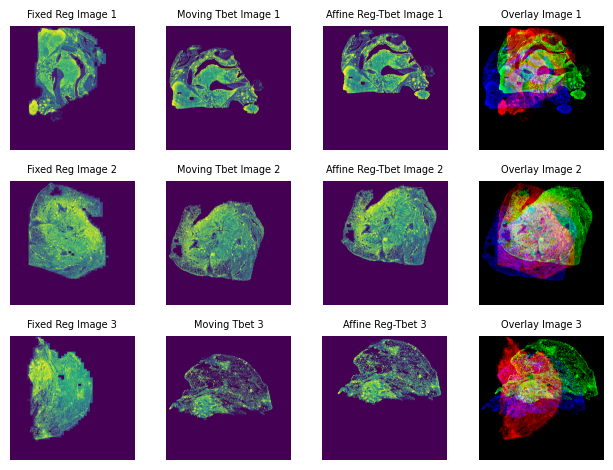

In [232]:
#Visualize the results

plt.subplot(3,4,1)
fixed_7 = exposure.equalize_hist(reg_image_cropped_ants_7_padded.numpy())
plt.imshow(fixed_7)
plt.title('Fixed Reg Image 1',fontsize=7)
plt.axis('off') 

plt.subplot(3,4,2)
moving_7 = exposure.equalize_hist(tbet_image_cropped_ants_7_padded.numpy())
plt.imshow(moving_7)
plt.title('Moving Tbet Image 1',fontsize=7)
plt.axis('off')

plt.subplot(3,4,3)
registered_7 = exposure.equalize_hist(affine_result_7['warpedmovout'].numpy())
plt.imshow(registered_7)
plt.title('Affine Reg-Tbet Image 1',fontsize=7)
plt.axis('off')

# Normalize the images to [0, 1] for proper overlay visualization
fixed_7_normalized = (fixed_7 - fixed_7.min()) / (fixed_7.max() - fixed_7.min())
registered_7_normalized = (registered_7 - registered_7.min()) / (registered_7.max() - registered_7.min())
moving_7_normalized = (moving_7 - moving_7.min()) / (moving_7.max() - moving_7.min())

#Overlay for the first image
plt.subplot(3, 4, 4)
overlay_7 = np.stack([fixed_7_normalized, registered_7_normalized, moving_7_normalized], axis=-1)  # Red for fixed, Blue for moving. Green for registered
plt.imshow(overlay_7)
plt.title('Overlay Image 1', fontsize=7)
plt.axis('off')

plt.subplot(3,4,5)
fixed_8 = exposure.equalize_hist(reg_image_cropped_ants_8_padded.numpy())
plt.imshow(fixed_8)
plt.title('Fixed Reg Image 2',fontsize=7)
plt.axis('off')

plt.subplot(3,4,6)
moving_8 = exposure.equalize_hist(tbet_image_cropped_ants_8_padded.numpy())
plt.imshow(moving_8)
plt.title('Moving Tbet Image 2', fontsize=7)
plt.axis('off')

plt.subplot(3,4,7)
registered_8 = exposure.equalize_hist(affine_result_8['warpedmovout'].numpy())
plt.imshow(registered_8)
plt.title('Affine Reg-Tbet Image 2',fontsize=7)
plt.axis('off')

# Normalize the images to [0, 1] for proper overlay visualization
fixed_8_normalized = (fixed_8 - fixed_8.min()) / (fixed_8.max() - fixed_8.min())
registered_8_normalized = (registered_8 - registered_8.min()) / (registered_8.max() - registered_8.min())
moving_8_normalized = (moving_8 - moving_8.min()) / (moving_8.max() - moving_8.min())

#Overlay for the second image
plt.subplot(3, 4, 8)
overlay_8 = np.stack([fixed_8_normalized, registered_8_normalized, moving_8_normalized], axis=-1)  # Red for fixed, Blue for moving. Green for registered
plt.imshow(overlay_8)
plt.title('Overlay Image 2', fontsize=7)
plt.axis('off')

plt.subplot(3,4,9)
fixed_9 = exposure.equalize_hist(reg_image_cropped_ants_9_padded.numpy())
plt.imshow(fixed_9)
plt.title('Fixed Reg Image 3',fontsize=7)
plt.axis('off')

plt.subplot(3,4,10)
moving_9 = exposure.equalize_hist(tbet_image_cropped_ants_9_padded.numpy())
plt.imshow(moving_9)
plt.title('Moving Tbet 3',fontsize=7)
plt.axis('off')

plt.subplot(3,4,11)
registered_9 = exposure.equalize_hist(affine_result_9['warpedmovout'].numpy())
plt.imshow(registered_9)
plt.title('Affine Reg-Tbet 3',fontsize=7)
plt.axis('off')

# Normalize the images to [0, 1] for proper overlay visualization
fixed_9_normalized = (fixed_9 - fixed_9.min()) / (fixed_9.max() - fixed_9.min())
registered_9_normalized = (registered_9 - registered_9.min()) / (registered_9.max() - registered_9.min())
moving_9_normalized = (moving_9 - moving_9.min()) / (moving_9.max() - moving_9.min())

#Overlay for the third image
plt.subplot(3,4,12)
overlay_9 = np.stack([fixed_9_normalized, registered_9_normalized, moving_9_normalized], axis=-1)  # Red for fixed, Blue for moving. Green for registered
plt.imshow(overlay_9)
plt.title('Overlay Image 3', fontsize=7)
plt.axis('off')
plt.tight_layout()
plt.show()



In [239]:
#View image metadata
affine_result_7

{'warpedmovout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (2048, 2048)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, -256.0)
 	 Direction  : [1. 0. 0. 1.],
 'warpedfixout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (2048, 2048)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (-256.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'fwdtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image7_0GenericAffine_scaled.mat',
  'C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image7_0GenericAffine.mat'],
 'invtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image7_0GenericAffine.mat',
  'C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image7_0GenericAffine_scaled.mat']}

In [240]:
#Get transform parameters
fwd_aff_7 = ants.read_transform(affine_result_7['fwdtransforms'][0])
fwd_aff_7_parameters_np = np.array(fwd_aff_7.parameters)
fwd_aff_7_parameters_np

array([ 9.99856174e-01, -1.65504944e-02,  1.65476594e-02,  9.99862909e-01,
       -9.62106228e+00,  2.05902710e+01])

In [241]:
#View image metadata
affine_result_8

{'warpedmovout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (2048, 2048)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, -256.0)
 	 Direction  : [1. 0. 0. 1.],
 'warpedfixout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (2048, 2048)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (-256.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'fwdtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image8_0GenericAffine.mat'],
 'invtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image8_0GenericAffine.mat']}

In [242]:
#Get transform parameters
fwd_aff_8 = ants.read_transform(affine_result_8['fwdtransforms'][0])
fwd_aff_8_parameters_np = np.array(fwd_aff_8.parameters)
fwd_aff_8_parameters_np

array([ 9.99990940e-01,  3.86249064e-03, -3.88079463e-03,  9.99992728e-01,
       -7.20446396e+00,  4.65930176e+00])

In [243]:
#View image metadata
affine_result_9

{'warpedmovout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (2048, 2048)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, -256.0)
 	 Direction  : [1. 0. 0. 1.],
 'warpedfixout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (2048, 2048)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (-256.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'fwdtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image9_0GenericAffine.mat'],
 'invtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image9_0GenericAffine.mat']}

In [200]:
#Get transform parameters
fwd_aff_9 = ants.read_transform(affine_result_9['fwdtransforms'][0])
fwd_aff_9_parameters_np = np.array(fwd_aff_9.parameters)
fwd_aff_9_parameters_np

array([ 9.99930263e-01, -1.12407915e-02,  1.12258466e-02,  9.99938965e-01,
       -1.23795691e+01,  4.62872314e+01])

### Metrics

In [244]:
# Compute mutual information
mi7 = ants.image_mutual_information(rigid_transformed_image_7, affine_result_7['warpedmovout'])
mi8 = ants.image_mutual_information(rigid_transformed_image_8, affine_result_8['warpedmovout'])
mi9 = ants.image_mutual_information(rigid_transformed_image_9, affine_result_9['warpedmovout'])

# Compute normalized cross-correlation
cc7 = ants.math.image_similarity(rigid_transformed_image_7,  affine_result_7['warpedmovout'], 'Correlation')
cc8 = ants.math.image_similarity(rigid_transformed_image_8, affine_result_8['warpedmovout'], 'Correlation')
cc9 = ants.math.image_similarity(rigid_transformed_image_9,  affine_result_9['warpedmovout'], 'Correlation')

# Compute mean squares
mse7 = ants.math.image_similarity(rigid_transformed_image_7,  affine_result_7['warpedmovout'], 'MeanSquares')
mse8 = ants.math.image_similarity(rigid_transformed_image_8,  affine_result_8['warpedmovout'], 'MeanSquares')
mse9 = ants.math.image_similarity(rigid_transformed_image_9, affine_result_9['warpedmovout'], 'MeanSquares')

In [ ]:
# Binarize the arrays (threshold = 0.5)

rigid_transformed_image_7_binary = (rigid_transformed_image_7.numpy() > 0.5).astype(int)
rigid_transformed_image_8_binary = (rigid_transformed_image_8.numpy() > 0.5).astype(int)    
rigid_transformed_image_9_binary = (rigid_transformed_image_9.numpy() > 0.5).astype(int)

affine_result_7_binary = (affine_result_7['warpedmovout'].numpy() > 0.5).astype(int)
affine_result_8_binary = (affine_result_8['warpedmovout'].numpy() > 0.5).astype(int)
affine_result_9_binary = (affine_result_9['warpedmovout'].numpy() > 0.5).astype(int)

In [ ]:
# Compute Jaccard Index
jaccard_7 = jaccard_score(rigid_transformed_image_7_binary.flatten(), affine_result_7_binary.flatten())
jaccard_8 = jaccard_score(rigid_transformed_image_8_binary.flatten(), affine_result_8_binary.flatten())
jaccard_9 = jaccard_score(rigid_transformed_image_9_binary.flatten(), affine_result_9_binary.flatten())

# Compute Dice Similarity Score
dice7 = f1_score(rigid_transformed_image_7_binary.flatten(), affine_result_7_binary.flatten())
dice8 = f1_score(rigid_transformed_image_8_binary.flatten(), affine_result_8_binary.flatten())
dice9 = f1_score(rigid_transformed_image_9_binary.flatten(), affine_result_9_binary.flatten())


In [245]:
# Compute Hausdorff Distance using SimpleITK
sitk_initial_image_7 = sitk.GetImageFromArray(rigid_transformed_image_7.numpy())
sitk_final_image_7 = sitk.GetImageFromArray(affine_result_7['warpedmovout'].numpy())

sitk_initial_image_8 = sitk.GetImageFromArray(rigid_transformed_image_8.numpy())
sitk_final_image_8 = sitk.GetImageFromArray(affine_result_8['warpedmovout'].numpy())

sitk_initial_image_9 = sitk.GetImageFromArray(rigid_transformed_image_9.numpy())
sitk_final_image_9 = sitk.GetImageFromArray(affine_result_9['warpedmovout'].numpy())

# Compute Hausdorff Distance for axis image 1 and final image 1
hausdorff_filter_7 = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_7.Execute(sitk_initial_image_7, sitk_final_image_7)
hausdorff_sitk_7 = hausdorff_filter_7.GetHausdorffDistance()

hausdorff_filter_8 = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_8.Execute(sitk_initial_image_8, sitk_final_image_8)
hausdorff_sitk_8 = hausdorff_filter_8.GetHausdorffDistance()

hausdorff_filter_9 = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_9.Execute(sitk_initial_image_9, sitk_final_image_9)
hausdorff_sitk_9 = hausdorff_filter_9.GetHausdorffDistance()


<Figure size 1000x600 with 0 Axes>

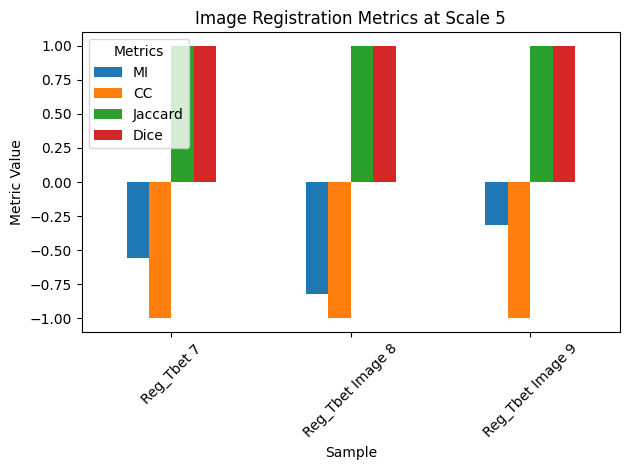

<Figure size 1000x600 with 0 Axes>

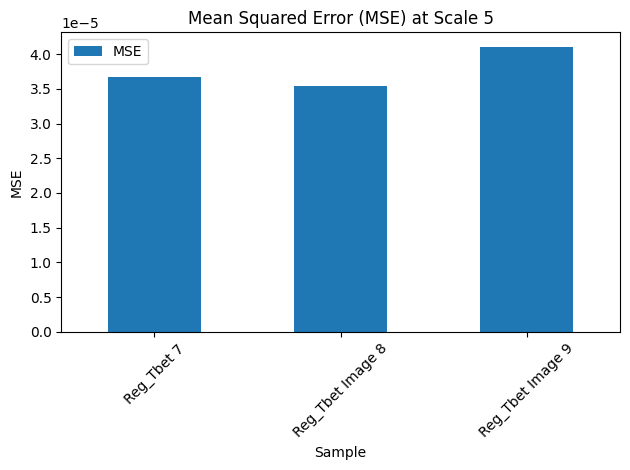

<Figure size 1000x600 with 0 Axes>

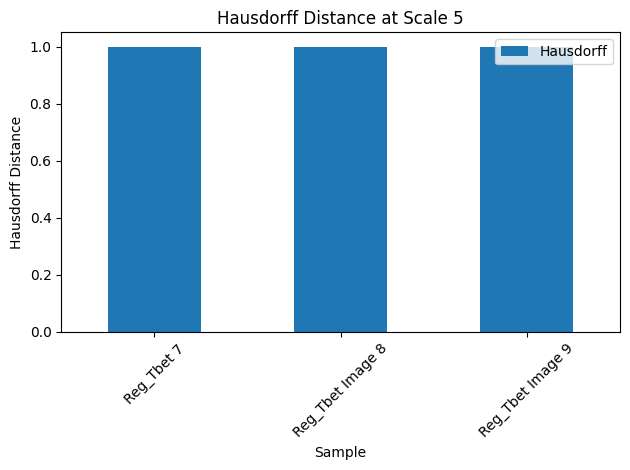

In [298]:
#Display the mi, cc, mse, jaccard, dice and hausdorff distance as graphs
metrics_df_2 = pd.DataFrame({
    'Sample': ['Reg_Tbet 7', 'Reg_Tbet Image 8', 'Reg_Tbet Image 9'],
    'MI': [mi7, mi8, mi9],
    'CC': [cc7, cc8, cc9],
    'MSE': [mse7, mse8, mse9],
    'Jaccard': [jaccard_7, jaccard_8, jaccard_9],
    'Dice': [dice7, dice8, dice9],
    'Hausdorff': [hausdorff_sitk_7, hausdorff_sitk_8, hausdorff_sitk_9]
})

# Set the index to the Sample ID
metrics_df_2.set_index('Sample', inplace=True)
# Plot the metrics minus hausdorff distance and mse
plt.figure(figsize=(10, 6))
metrics_df_2[['MI', 'CC', 'Jaccard', 'Dice']].plot(kind='bar')
plt.title('Image Registration Metrics at Scale 5')
plt.ylabel('Metric Value')
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

# Plot the Mean Squared Error (MSE)
plt.figure(figsize=(10, 6))
metrics_df_2[['MSE']].plot(kind='bar')
plt.title('Mean Squared Error (MSE) at Scale 5')
plt.ylabel('MSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot the Hausdorff distance
plt.figure(figsize=(10, 6))
metrics_df_2[['Hausdorff']].plot(kind='bar')
plt.title('Hausdorff Distance at Scale 5')
plt.ylabel('Hausdorff Distance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


    

In [320]:
# Convert each set of corresponding tissue slices into a DataFrame
#Each row has the same tissue, but 3 different slices representing the same tissue stained with the axis, regression and tbet panels
#Each different row represents a different tissue

# Concatenate the rows into a single DataFrame
merged_df_3 = pd.concat([row_1, row_2, row_3], ignore_index=True)

#Add columns to the merged DataFrame
merged_df_3['scale'] = [5,5,5]
merged_df_3['final_image_fixed_parameters'] = [fwd_aff_4.fixed_parameters,fwd_aff_5.fixed_parameters,fwd_aff_6.fixed_parameters]
merged_df_3['final_image_parameters'] = [fwd_aff_4.parameters,fwd_aff_5.parameters,fwd_aff_6.parameters]
merged_df_3['mi_reg_tbet_transformed'] = [mi7,mi8,mi9]
merged_df_3['cc_reg_tbet_transformed'] = [cc7,cc8,cc9]
merged_df_3['mse_reg_tbet_transformed'] = [mse7,mse8,mse9]
merged_df_3['jaccard_reg_tbet_transformed'] = [jaccard_7,jaccard_8,jaccard_9]
merged_df_3['dice_reg_tbet_transformed'] = [dice7,dice8,dice9]
merged_df_3['hausdorff_reg_tbet_transformed'] = [hausdorff_sitk_7,hausdorff_sitk_8,hausdorff_sitk_9]

merged_df_3

,sampleid,reg_sampleid,tbet_sampleid,slideid,reg_slideid,tbet_slideid,scale,final_image_fixed_parameters,final_image_parameters,mi_reg_tbet_transformed,cc_reg_tbet_transformed,mse_reg_tbet_transformed,jaccard_reg_tbet_transformed,dice_reg_tbet_transformed,hausdorff_reg_tbet_transformed
0,101,709.0,834.0,L1_2,LY1,AP0140001,5,"[174.8902587890625, 168.3602294921875]","[0.9998630881309509, -0.016547514125704765, 0....",-0.560004,-0.999994,0.000037,0.999428,0.999714,1.0
1,107,710.0,835.0,L2_4,LY2,AP0140002,5,"[188.212158203125, 203.15960693359375]","[0.9999925494194031, 0.0038658608682453632, -0...",-0.820464,-0.999992,0.000035,0.999398,0.999699,1.0
2,535,712.0,837.0,L4_3,LY4,AP0140004,5,"[172.20706176757812, 181.14254760742188]","[0.9999368786811829, -0.011237968690693378, 0....",-0.315788,-0.999991,0.000041,0.998512,0.999255,1.0


In [316]:
merged_df_3.to_csv('C:/Users/molanre1/Desktop/WSIFIR/xform_reg_to_tbet_scale_5.csv', index=False)

## Affine Regression (Scale 3)

### Load in spatial data

In [228]:
#Loop through each image in sp.images and crop it
cropped_images_4 = {}
for sampleid in sp.images:
    cropped_images_4[sampleid] = tl.crop_xarray_image(sp.images[sampleid], scale=3)[0]


#Create a dataframe with a columnn named panel that loops either axis, regression and tbet 3 time
panel_4 = ['regression','tbet']*3
panel_df_4 = pd.DataFrame(panel, columns=['panel'])

#Save dimensions of the cropped images to a dataframe
cropped_images_dimensions_4 = {}
for sampleid, cropped_image in cropped_images_4.items():
    cropped_images_dimensions_4[sampleid] = {
        'dimensions': cropped_image.shape,
        'data_type': cropped_image.dtype,
        'coordinates': cropped_image.coords,
    }

cropped_images_dimensions_df_4 = pd.DataFrame.from_dict(cropped_images_dimensions_4, orient='index')
#Add the panel column to the cropped images dimensions dataframe
cropped_images_dimensions_df_4['panel'] = panel_df_4['panel'].values
cropped_images_dimensions_df_4



,dimensions,data_type,coordinates,panel
sampleid_709_image,"(8192, 6144)",float32,"[c, y, x]",regression
sampleid_834_image,"(6144, 8192)",float32,"[c, y, x]",tbet
sampleid_710_image,"(8192, 6144)",float32,"[c, y, x]",regression
sampleid_835_image,"(6144, 8192)",float32,"[c, y, x]",tbet
sampleid_712_image,"(8192, 6144)",float32,"[c, y, x]",regression
sampleid_837_image,"(6144, 8192)",float32,"[c, y, x]",tbet


In [229]:
#Cronvert the cropped images to ants
reg_image_cropped_ants_10 = ants.from_numpy(cropped_images_4[f'sampleid_{results[0]["reg_sampleid"]}_image'].compute().data)
tbet_image_cropped_ants_10 = ants.from_numpy(cropped_images_4[f'sampleid_{results[0]["tbet_sampleid"]}_image'].compute().data)

reg_image_cropped_ants_11 = ants.from_numpy(cropped_images_4[f'sampleid_{results[1]["reg_sampleid"]}_image'].compute().data)
tbet_image_cropped_ants_11 = ants.from_numpy(cropped_images_4[f'sampleid_{results[1]["tbet_sampleid"]}_image'].compute().data)

reg_image_cropped_ants_12 = ants.from_numpy(cropped_images_4[f'sampleid_{results[2]["reg_sampleid"]}_image'].compute().data)
tbet_image_cropped_ants_12 = ants.from_numpy(cropped_images_4[f'sampleid_{results[2]["tbet_sampleid"]}_image'].compute().data)


### Pad Images

In [221]:
#Pad the images so they are the same size
reg_image_cropped_shape_10 = reg_image_cropped_ants_10.shape
tbet_image_cropped_shape_10= tbet_image_cropped_ants_10.shape

reg_image_cropped_shape_11 = reg_image_cropped_ants_11.shape
tbet_image_cropped_shape_11= tbet_image_cropped_ants_11.shape

reg_image_cropped_shape_12 = reg_image_cropped_ants_12.shape
tbet_image_cropped_shape_12= tbet_image_cropped_ants_12.shape

#Get the target shapes for padding
target_shape_10_x = max(reg_image_cropped_shape_10[0],tbet_image_cropped_shape_10[0])
target_shape_10_y = max(reg_image_cropped_shape_10[1],tbet_image_cropped_shape_10[1])

target_shape_11_x = max(reg_image_cropped_shape_11[0],tbet_image_cropped_shape_11[0])
target_shape_11_y = max(reg_image_cropped_shape_11[1],tbet_image_cropped_shape_11[1])

target_shape_12_x = max(reg_image_cropped_shape_12[0],tbet_image_cropped_shape_12[0])
target_shape_12_y = max(reg_image_cropped_shape_12[1],tbet_image_cropped_shape_12[1])

#Calculate the padding
pad_reg_X_10 = (0,target_shape_10_x-reg_image_cropped_shape_10[0])
pad_reg_Y_10 = (0,target_shape_10_y-reg_image_cropped_shape_10[1])

pad_reg_X_11 = (0,target_shape_11_x-reg_image_cropped_shape_11[0])
pad_reg_Y_11 = (0,target_shape_11_y-reg_image_cropped_shape_11[1])

pad_reg_X_12 = (0,target_shape_12_x-reg_image_cropped_shape_12[0])
pad_reg_Y_12 = (0,target_shape_12_y-reg_image_cropped_shape_12[1])

# Pad the cropped images to match the size of the rigid transformed images
reg_image_cropped_ants_10_padded = ants.pad_image(reg_image_cropped_ants_10, (target_shape_10_x,target_shape_10_y))
reg_image_cropped_ants_11_padded = ants.pad_image(reg_image_cropped_ants_11, (target_shape_11_x,target_shape_11_y))
reg_image_cropped_ants_12_padded = ants.pad_image(reg_image_cropped_ants_12, (target_shape_12_x,target_shape_12_y))

# Pad the tbet images to match the size of the rigid transformed images
tbet_image_cropped_ants_10_padded = ants.pad_image(tbet_image_cropped_ants_10, (target_shape_10_x,target_shape_10_y))
tbet_image_cropped_ants_11_padded = ants.pad_image(tbet_image_cropped_ants_11, (target_shape_11_x,target_shape_11_y))
tbet_image_cropped_ants_12_padded = ants.pad_image(tbet_image_cropped_ants_12, (target_shape_12_x,target_shape_12_y))

# Print the shapes of the padded images
print("Padded regression image shape 10: ", reg_image_cropped_ants_10_padded.shape)
print("Padded regression image shape 11: ", reg_image_cropped_ants_11_padded.shape)
print("Padded regression image shape 12: ", reg_image_cropped_ants_12_padded.shape,"\n")

print("Padded tbet image shape 10: ", tbet_image_cropped_ants_10_padded.shape)
print("Padded tbet image shape 11: ", tbet_image_cropped_ants_11_padded.shape)
print("Padded tbet image shape 12: ", tbet_image_cropped_ants_12_padded.shape,"\n")

Padded regression image shape 10:  (8192, 8192)
Padded regression image shape 11:  (8192, 8192)
Padded regression image shape 12:  (8192, 8192) 

Padded tbet image shape 10:  (8192, 8192)
Padded tbet image shape 11:  (8192, 8192)
Padded tbet image shape 12:  (8192, 8192) 



### Scale and apply registration parameters at lower resolution to higher resolution image

In [223]:
# Compute scaling factor and adjust transformations for each image
low_res_image_7 = reg_image_cropped_ants_7_padded  # Low-resolution image
high_res_image_7 = reg_image_cropped_ants_10_padded  # High-resolution image

low_res_image_8 = reg_image_cropped_ants_8_padded  # Low-resolution image
high_res_image_8 = reg_image_cropped_ants_11_padded  # High-resolution image

low_res_image_9 = reg_image_cropped_ants_9_padded  # Low-resolution image
high_res_image_9 = reg_image_cropped_ants_12_padded  # High-resolution image

# Compute scaling factors
scaling_factor_7 = compute_scaling_factor(low_res_image_7, high_res_image_7)
scaling_factor_8 = compute_scaling_factor(low_res_image_8, high_res_image_8)
scaling_factor_9 = compute_scaling_factor(low_res_image_9, high_res_image_9)

### ANTS Affine transform

In [251]:
#Apply the scaling factors to the transformations

scaled_transform_10 = scale_transform(
    'C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image7_0GenericAffine.mat',
    scaling_factor_7
)

# Apply the scaled transformation to the image
affine_transformed_image_10 = ants.apply_transforms(
    fixed=reg_image_cropped_ants_10_padded,
    moving=tbet_image_cropped_ants_10_padded,
    transformlist=scaled_transform_10
)

# Perform affine registration first on the image
affine_result_10 = ants.registration(
    fixed=affine_transformed_image_10,
    moving=tbet_image_cropped_ants_10_padded,
    type_of_transform='Affine',
    verbose=True,
    outprefix='C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image10_'
)

# Apply the scaling factors to the transformations
scaled_transform_11 = scale_transform(
    'C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image8_0GenericAffine.mat',
    scaling_factor_8
)

# Apply the scaled transformation to the image
affine_transformed_image_11 = ants.apply_transforms(
    fixed=reg_image_cropped_ants_11_padded,
    moving=tbet_image_cropped_ants_11_padded,
    transformlist=scaled_transform_11
)

# Perform affine registration first on the image
affine_result_11 = ants.registration(
    fixed=affine_transformed_image_11,
    moving=tbet_image_cropped_ants_11_padded,
    type_of_transform='Affine',
    verbose=True,
    outprefix='C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image11_'
)

# Apply the scaling factors to the transformations
scaled_transform_12 = scale_transform(
    'C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image9_0GenericAffine.mat',
    scaling_factor_9
)

# Apply the scaled transformation to the image
affine_transformed_image_12 = ants.apply_transforms(
    fixed=reg_image_cropped_ants_12_padded,
    moving=tbet_image_cropped_ants_12_padded,
    transformlist=scaled_transform_12
)

# Perform affine registration first on the image
affine_result_12 = ants.registration(
    fixed=affine_transformed_image_12,
    moving=tbet_image_cropped_ants_12_padded,
    type_of_transform='Affine',
    verbose=True,
    outprefix='C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image12_'
)

antsRegistration -d 2 -r [0000021311318F08,0000021311268588,1] -m mattes[0000021311318F08,0000021311268588,1,32,regular,0.2] -t Affine[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:\Users\molanre1\Desktop\WSIFIR\reg_tbet_affine_registration_image10_,0000021314CED408,0000021314CEE748] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r [0000021314CEE748,0000021314CED408,1] -m mattes[0000021314CEE748,0000021314CED408,1,32,regular,0.2] -t Affine[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:\Users\molanre1\Desktop\WSIFIR\reg_tbet_affine_registration_image11_,000002131135FD68,0000021311318F08] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r [0000021314CED408,0000021314CEE748,1] -m mattes[0000021314CED408,0000021314CEE748,1,32,regular,0.2] -t Affine[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:\Users\molanre1\Desktop\WSIFIR\reg_tbet_affine_registration_image12_,00000213120

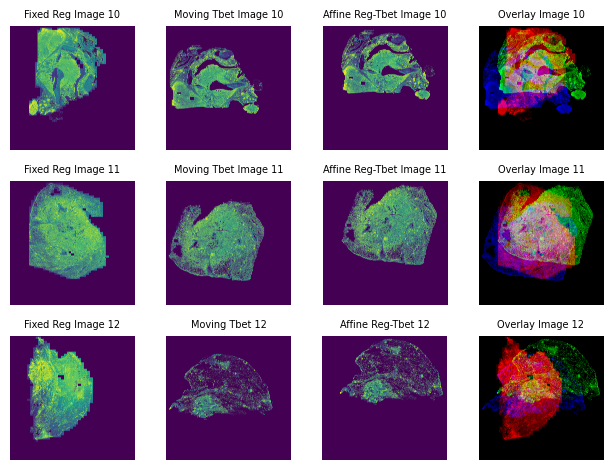

In [253]:
#Visualize the results
plt.subplot(3,4,1)
fixed_10 = exposure.equalize_hist(reg_image_cropped_ants_10_padded.numpy())
plt.imshow(fixed_10)
plt.title('Fixed Reg Image 10',fontsize=7)
plt.axis('off')

plt.subplot(3,4,2)
moving_10 = exposure.equalize_hist(tbet_image_cropped_ants_10_padded.numpy())
plt.imshow(moving_10)
plt.title('Moving Tbet Image 10',fontsize=7)
plt.axis('off')

plt.subplot(3,4,3)
registered_10 = exposure.equalize_hist(affine_result_10['warpedmovout'].numpy())
plt.imshow(registered_10)
plt.title('Affine Reg-Tbet Image 10',fontsize=7)
plt.axis('off')

# Normalize the images to [0, 1] for proper overlay visualization
fixed_10_normalized = (fixed_10 - fixed_10.min()) / (fixed_10.max() - fixed_10.min())
registered_10_normalized = (registered_10 - registered_10.min()) / (registered_10.max() - registered_10.min())
moving_10_normalized = (moving_10 - moving_10.min()) / (moving_10.max() - moving_10.min())

#Overlay for the first image
plt.subplot(3, 4, 4)
overlay_10 = np.stack([fixed_10_normalized, registered_10_normalized, moving_10_normalized], axis=-1)  # Red for fixed, Blue for moving. Green for registered
plt.imshow(overlay_10)
plt.title('Overlay Image 10', fontsize=7)
plt.axis('off')

plt.subplot(3,4,5)
fixed_11 = exposure.equalize_hist(reg_image_cropped_ants_11_padded.numpy())
plt.imshow(fixed_11)
plt.title('Fixed Reg Image 11',fontsize=7)
plt.axis('off')

plt.subplot(3,4,6)
moving_11 = exposure.equalize_hist(tbet_image_cropped_ants_11_padded.numpy())
plt.imshow(moving_11)
plt.title('Moving Tbet Image 11', fontsize=7)
plt.axis('off')

plt.subplot(3,4,7)
registered_11 = exposure.equalize_hist(affine_result_11['warpedmovout'].numpy())
plt.imshow(registered_11)
plt.title('Affine Reg-Tbet Image 11',fontsize=7)

plt.axis('off')
# Normalize the images to [0, 1] for proper overlay visualization
fixed_11_normalized = (fixed_11 - fixed_11.min()) / (fixed_11.max() - fixed_11.min())
registered_11_normalized = (registered_11 - registered_11.min()) / (registered_11.max() - registered_11.min())
moving_11_normalized = (moving_11 - moving_11.min()) / (moving_11.max() - moving_11.min())

#Overlay for the second image
plt.subplot(3, 4, 8)
overlay_11 = np.stack([fixed_11_normalized, registered_11_normalized, moving_11_normalized], axis=-1)  # Red for fixed, Blue for moving. Green for registered
plt.imshow(overlay_11)
plt.title('Overlay Image 11', fontsize=7)
plt.axis('off')

plt.subplot(3,4,9)
fixed_12 = exposure.equalize_hist(reg_image_cropped_ants_12_padded.numpy())
plt.imshow(fixed_12)
plt.title('Fixed Reg Image 12',fontsize=7)
plt.axis('off')

plt.subplot(3,4,10)
moving_12 = exposure.equalize_hist(tbet_image_cropped_ants_12_padded.numpy())
plt.imshow(moving_12)
plt.title('Moving Tbet 12',fontsize=7)
plt.axis('off')

plt.subplot(3,4,11)
registered_12 = exposure.equalize_hist(affine_result_12['warpedmovout'].numpy())
plt.imshow(registered_12)
plt.title('Affine Reg-Tbet 12',fontsize=7)
plt.axis('off')

# Normalize the images to [0, 1] for proper overlay visualization
fixed_12_normalized = (fixed_12 - fixed_12.min()) / (fixed_12.max() - fixed_12.min())
registered_12_normalized = (registered_12 - registered_12.min()) / (registered_12.max() - registered_12.min())
moving_12_normalized = (moving_12 - moving_12.min()) / (moving_12.max() - moving_12.min())

#Overlay for the third image
plt.subplot(3,4,12)
overlay_12 = np.stack([fixed_12_normalized, registered_12_normalized, moving_12_normalized], axis=-1)  # Red for fixed, Blue for moving. Green for registered
plt.imshow(overlay_12)
plt.title('Overlay Image 12', fontsize=7)
plt.axis('off')

plt.tight_layout()
plt.show()

### Metrics

In [306]:
#Compute mutual information
mi10 = ants.image_mutual_information(affine_transformed_image_10, affine_result_10['warpedmovout'])
mi11 = ants.image_mutual_information(affine_transformed_image_11, affine_result_11['warpedmovout'])
mi12 = ants.image_mutual_information(affine_transformed_image_12, affine_result_12['warpedmovout'])

# Compute normalized cross-correlation
cc10 = ants.math.image_similarity(affine_transformed_image_10,  affine_result_10['warpedmovout'], 'Correlation')
cc11 = ants.math.image_similarity(affine_transformed_image_11, affine_result_11['warpedmovout'], 'Correlation')
cc12 = ants.math.image_similarity(affine_transformed_image_12,  affine_result_12['warpedmovout'], 'Correlation')

# Compute mean squares
mse10 = ants.math.image_similarity(affine_transformed_image_10,  affine_result_10['warpedmovout'], 'MeanSquares')
mse11 = ants.math.image_similarity(affine_transformed_image_11,  affine_result_11['warpedmovout'], 'MeanSquares')
mse12 = ants.math.image_similarity(affine_transformed_image_12,  affine_result_12['warpedmovout'], 'MeanSquares')

In [302]:
# Binarize the arrays (threshold = 0.5)

affine_transformed_image_10_binary = (affine_transformed_image_10.numpy() > 0.5).astype(int)
affine_transformed_image_11_binary = (affine_transformed_image_11.numpy() > 0.5).astype(int)
affine_transformed_image_12_binary = (affine_transformed_image_12.numpy() > 0.5).astype(int)

affine_result_10_binary = (affine_result_10['warpedmovout'].numpy() > 0.5).astype(int)
affine_result_11_binary = (affine_result_11['warpedmovout'].numpy() > 0.5).astype(int)
affine_result_12_binary = (affine_result_12['warpedmovout'].numpy() > 0.5).astype(int)

In [303]:
# Compute Jaccard Index
jaccard_10 = jaccard_score(affine_transformed_image_10_binary.flatten(), affine_result_10_binary.flatten())
jaccard_11 = jaccard_score(affine_transformed_image_11_binary.flatten(), affine_result_11_binary.flatten())
jaccard_12 = jaccard_score(affine_transformed_image_12_binary.flatten(), affine_result_12_binary.flatten())

# Compute Dice Similarity Score
dice10 = f1_score(affine_transformed_image_10_binary.flatten(), affine_result_10_binary.flatten())
dice11 = f1_score(affine_transformed_image_11_binary.flatten(), affine_result_11_binary.flatten())
dice12 = f1_score(affine_transformed_image_12_binary.flatten(), affine_result_12_binary.flatten())


In [301]:
# Compute Hausdorff Distance using SimpleITK
sitk_initial_image_10 = sitk.GetImageFromArray(affine_transformed_image_10.numpy())
sitk_final_image_10 = sitk.GetImageFromArray(affine_result_10['warpedmovout'].numpy())

sitk_initial_image_11 = sitk.GetImageFromArray(affine_transformed_image_11.numpy()) 
sitk_final_image_11 = sitk.GetImageFromArray(affine_result_11['warpedmovout'].numpy())

sitk_initial_image_12 = sitk.GetImageFromArray(affine_transformed_image_12.numpy())
sitk_final_image_12 = sitk.GetImageFromArray(affine_result_12['warpedmovout'].numpy())

# Compute Hausdorff Distance for axis image 1 and final image 1
hausdorff_filter_10 = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_10.Execute(sitk_initial_image_10, sitk_final_image_10)
hausdorff_sitk_10 = hausdorff_filter_10.GetHausdorffDistance()

hausdorff_filter_11 = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_11.Execute(sitk_initial_image_11, sitk_final_image_11)

hausdorff_sitk_11 = hausdorff_filter_11.GetHausdorffDistance()
hausdorff_filter_12 = sitk.HausdorffDistanceImageFilter()

hausdorff_filter_12.Execute(sitk_initial_image_12, sitk_final_image_12)
hausdorff_sitk_12 = hausdorff_filter_12.GetHausdorffDistance()


<Figure size 1000x600 with 0 Axes>

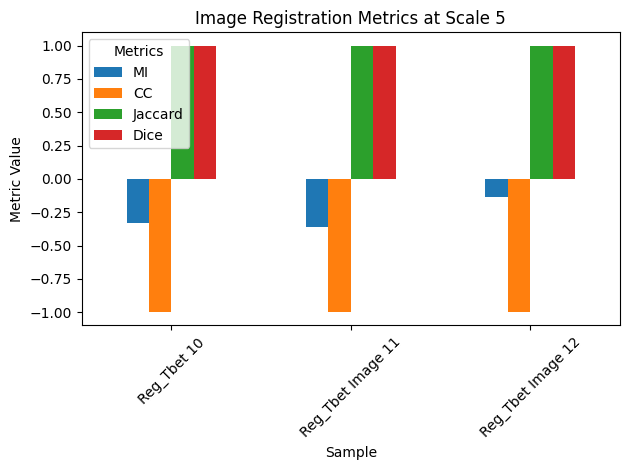

<Figure size 1000x600 with 0 Axes>

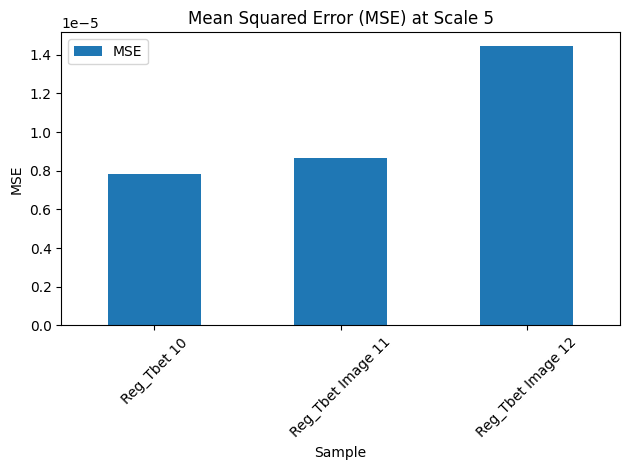

<Figure size 1000x600 with 0 Axes>

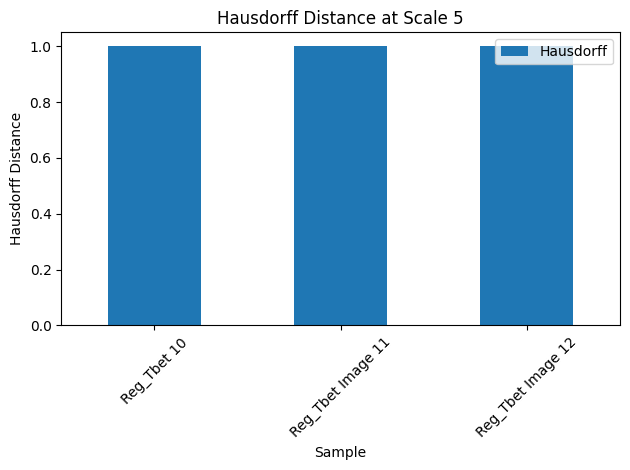

In [308]:
metrics_df_4 = pd.DataFrame(
    {
        'Sample': ['Reg_Tbet 10', 'Reg_Tbet Image 11', 'Reg_Tbet Image 12'],
        'MI': [mi10, mi11, mi12],
        'CC': [cc10, cc11, cc12],
        'MSE': [mse10, mse11, mse12],
        'Jaccard': [jaccard_10, jaccard_11, jaccard_12],
        'Dice': [dice10, dice11, dice12],
        'Hausdorff': [hausdorff_sitk_10, hausdorff_sitk_11, hausdorff_sitk_12]
    }
)

# Set the index to the Sample ID

metrics_df_4.set_index('Sample', inplace=True)
# Plot the metrics minus hausdorff distance and mse
plt.figure(figsize=(10, 6))
metrics_df_4[['MI', 'CC', 'Jaccard', 'Dice']].plot(kind='bar')
plt.title('Image Registration Metrics at Scale 5')
plt.ylabel('Metric Value')
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

# Plot the Mean Squared Error (MSE)
plt.figure(figsize=(10, 6))
metrics_df_4[['MSE']].plot(kind='bar')
plt.title('Mean Squared Error (MSE) at Scale 5')
plt.ylabel('MSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot the Hausdorff distance
plt.figure(figsize=(10, 6))
metrics_df_4[['Hausdorff']].plot(kind='bar')
plt.title('Hausdorff Distance at Scale 5')
plt.ylabel('Hausdorff Distance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [319]:
# Convert each set of corresponding tissue slices into a DataFrame
#Each row has the same tissue, but 3 different slices representing the same tissue stained with the axis, regression and tbet panels
#Each different row represents a different tissue

# Concatenate the rows into a single DataFrame
merged_df_4 = pd.concat([row_1, row_2, row_3], ignore_index=True)
#Add columns to the merged DataFrame
merged_df_4['scale'] = [3,3,3]
merged_df_4['final_image_fixed_parameters'] = [fwd_aff_7.fixed_parameters,fwd_aff_8.fixed_parameters,fwd_aff_9.fixed_parameters]
merged_df_4['final_image_parameters'] = [fwd_aff_7.parameters,fwd_aff_8.parameters,fwd_aff_9.parameters]
merged_df_4['mi_reg_tbet_transformed'] = [mi10,mi11,mi12]
merged_df_4['cc_reg_tbet_transformed'] = [cc10,cc11,cc12]
merged_df_4['mse_reg_tbet_transformed'] = [mse10,mse11,mse12]
merged_df_4['jaccard_reg_tbet_transformed'] = [jaccard_10,jaccard_11,jaccard_12]
merged_df_4['dice_reg_tbet_transformed'] = [dice10,dice11,dice12]
merged_df_4['hausdorff_reg_tbet_transformed'] = [hausdorff_sitk_10,hausdorff_sitk_11,hausdorff_sitk_12] 

merged_df_4

,sampleid,reg_sampleid,tbet_sampleid,slideid,reg_slideid,tbet_slideid,scale,final_image_fixed_parameters,final_image_parameters,mi_reg_tbet_transformed,cc_reg_tbet_transformed,mse_reg_tbet_transformed,jaccard_reg_tbet_transformed,dice_reg_tbet_transformed,hausdorff_reg_tbet_transformed
0,101,709.0,834.0,L1_2,LY1,AP0140001,3,"[707.822021484375, 701.7154541015625]","[0.999856173992157, -0.016550494357943535, 0.0...",-0.332173,-0.999999,0.000008,0.999862,0.999931,1.0
1,107,710.0,835.0,L2_4,LY2,AP0140002,3,"[722.8814697265625, 836.417724609375]","[0.9999909400939941, 0.0038624906446784735, -0...",-0.364629,-0.999999,0.000009,0.999718,0.999859,1.0
2,535,712.0,837.0,L4_3,LY4,AP0140004,3,"[683.033935546875, 842.1544799804688]","[0.9999302625656128, -0.011240791529417038, 0....",-0.137988,-0.999998,0.000014,0.999523,0.999762,1.0


## Symmetric Deformable Registration (Scale 2)

### Load in spatial data

In [309]:
#Loop through each image in sp.images and crop it
cropped_images_5 = {}
for sampleid in sp.images:
    cropped_images_5[sampleid] = tl.crop_xarray_image(sp.images[sampleid], scale=2)[0]


#Create a dataframe with a columnn named panel that loops either axis, regression and tbet 3 time
panel_5 = ['regression','tbet']*3
panel_df_5 = pd.DataFrame(panel, columns=['panel'])

#Save dimensions of the cropped images to a dataframe
cropped_images_dimensions_5 = {}
for sampleid, cropped_image in cropped_images_5.items():
    cropped_images_dimensions_5[sampleid] = {
        'dimensions': cropped_image.shape,
        'data_type': cropped_image.dtype,
        'coordinates': cropped_image.coords,
    }

cropped_images_dimensions_df_5 = pd.DataFrame.from_dict(cropped_images_dimensions_5, orient='index')
#Add the panel column to the cropped images dimensions dataframe
cropped_images_dimensions_df_5['panel'] = panel_df_5['panel'].values
cropped_images_dimensions_df_5

,dimensions,data_type,coordinates,panel
sampleid_709_image,"(16384, 12288)",float32,"[c, y, x]",regression
sampleid_834_image,"(12288, 16384)",float32,"[c, y, x]",tbet
sampleid_710_image,"(16384, 12288)",float32,"[c, y, x]",regression
sampleid_835_image,"(12288, 16384)",float32,"[c, y, x]",tbet
sampleid_712_image,"(16384, 12288)",float32,"[c, y, x]",regression
sampleid_837_image,"(12288, 16384)",float32,"[c, y, x]",tbet


In [321]:
#Convret the cropped images to ants
reg_image_cropped_ants_13 = ants.from_numpy(cropped_images_5[f'sampleid_{results[0]["reg_sampleid"]}_image'].compute().data)
tbet_image_cropped_ants_13 = ants.from_numpy(cropped_images_5[f'sampleid_{results[0]["tbet_sampleid"]}_image'].compute().data)

reg_image_cropped_ants_14 = ants.from_numpy(cropped_images_5[f'sampleid_{results[1]["reg_sampleid"]}_image'].compute().data)
tbet_image_cropped_ants_14 = ants.from_numpy(cropped_images_5[f'sampleid_{results[1]["tbet_sampleid"]}_image'].compute().data)

reg_image_cropped_ants_15 = ants.from_numpy(cropped_images_5[f'sampleid_{results[2]["reg_sampleid"]}_image'].compute().data)
tbet_image_cropped_ants_15 = ants.from_numpy(cropped_images_5[f'sampleid_{results[2]["tbet_sampleid"]}_image'].compute().data)

In [322]:
#Pad the images so they are the same size

reg_image_cropped_shape_13 = reg_image_cropped_ants_13.shape
tbet_image_cropped_shape_13= tbet_image_cropped_ants_13.shape

reg_image_cropped_shape_14 = reg_image_cropped_ants_14.shape
tbet_image_cropped_shape_14= tbet_image_cropped_ants_14.shape

reg_image_cropped_shape_15 = reg_image_cropped_ants_15.shape
tbet_image_cropped_shape_15= tbet_image_cropped_ants_15.shape


#Get the target shapes for padding
target_shape_13_x = max(reg_image_cropped_shape_13[0],tbet_image_cropped_shape_13[0])
target_shape_13_y = max(reg_image_cropped_shape_13[1],tbet_image_cropped_shape_13[1])

target_shape_14_x = max(reg_image_cropped_shape_14[0],tbet_image_cropped_shape_14[0])
target_shape_14_y = max(reg_image_cropped_shape_14[1],tbet_image_cropped_shape_14[1])

target_shape_15_x = max(reg_image_cropped_shape_15[0],tbet_image_cropped_shape_15[0])
target_shape_15_y = max(reg_image_cropped_shape_15[1],tbet_image_cropped_shape_15[1])

#Calculate the padding
pad_reg_X_13 = (0,target_shape_13_x-reg_image_cropped_shape_13[0])
pad_reg_Y_13 = (0,target_shape_13_y-reg_image_cropped_shape_13[1])

pad_reg_X_14 = (0,target_shape_14_x-reg_image_cropped_shape_14[0])
pad_reg_Y_14 = (0,target_shape_14_y-reg_image_cropped_shape_14[1])

pad_reg_X_15 = (0,target_shape_15_x-reg_image_cropped_shape_15[0])
pad_reg_Y_15 = (0,target_shape_15_y-reg_image_cropped_shape_15[1])

# Pad the cropped images to match the size of the rigid transformed images
reg_image_cropped_ants_13_padded = ants.pad_image(reg_image_cropped_ants_13, (target_shape_13_x,target_shape_13_y))
reg_image_cropped_ants_14_padded = ants.pad_image(reg_image_cropped_ants_14, (target_shape_14_x,target_shape_14_y))
reg_image_cropped_ants_15_padded = ants.pad_image(reg_image_cropped_ants_15, (target_shape_15_x,target_shape_15_y))

# Pad the tbet images to match the size of the rigid transformed images
tbet_image_cropped_ants_13_padded = ants.pad_image(tbet_image_cropped_ants_13, (target_shape_13_x,target_shape_13_y))
tbet_image_cropped_ants_14_padded = ants.pad_image(tbet_image_cropped_ants_14, (target_shape_14_x,target_shape_14_y))
tbet_image_cropped_ants_15_padded = ants.pad_image(tbet_image_cropped_ants_15, (target_shape_15_x,target_shape_15_y))

# Print the shapes of the padded images
print("Padded regression image shape 13: ", reg_image_cropped_ants_13_padded.shape)
print("Padded regression image shape 14: ", reg_image_cropped_ants_14_padded.shape)
print("Padded regression image shape 15: ", reg_image_cropped_ants_15_padded.shape,"\n")

print("Padded tbet image shape 13: ", tbet_image_cropped_ants_13_padded.shape)
print("Padded tbet image shape 14: ", tbet_image_cropped_ants_14_padded.shape)
print("Padded tbet image shape 15: ", tbet_image_cropped_ants_15_padded.shape,"\n")


Padded regression image shape 13:  (16384, 16384)
Padded regression image shape 14:  (16384, 16384)
Padded regression image shape 15:  (16384, 16384) 

Padded tbet image shape 13:  (16384, 16384)
Padded tbet image shape 14:  (16384, 16384)
Padded tbet image shape 15:  (16384, 16384) 



### Scale and apply registration parameters at lower resolution to higher resolution image

In [323]:
#Compute scaling factor and adjust transformations for each image
low_res_image_10 = reg_image_cropped_ants_10_padded  # Low-resolution image
high_res_image_10 = reg_image_cropped_ants_13_padded  # High-resolution image

low_res_image_11 = reg_image_cropped_ants_11_padded  # Low-resolution image
high_res_image_11 = reg_image_cropped_ants_14_padded  # High-resolution image

low_res_image_12 = reg_image_cropped_ants_12_padded  # Low-resolution image
high_res_image_12 = reg_image_cropped_ants_15_padded  # High-resolution image

# Compute scaling factors
scaling_factor_10 = compute_scaling_factor(low_res_image_10, high_res_image_10)
scaling_factor_11 = compute_scaling_factor(low_res_image_11, high_res_image_11)
scaling_factor_12 = compute_scaling_factor(low_res_image_12, high_res_image_12)

### ANTS Symmetric Deformable transform

In [ ]:
#Divide image into sections

In [329]:

#Apply the scaling factors to the transformations
scaled_transform_13 = scale_transform(
    'C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image7_0GenericAffine.mat',
    scaling_factor_10
)

# Apply the scaled transformation to the image
affine_transformed_image_13 = ants.apply_transforms(
    fixed=reg_image_cropped_ants_13_padded,
    moving=tbet_image_cropped_ants_13_padded,
    transformlist=scaled_transform_13
)

# Perform SyN registration first on the image
syn_result_13 = ants.registration(  
    fixed=affine_transformed_image_13,
    moving=tbet_image_cropped_ants_13_padded,
    type_of_transform='SyN',
    verbose=True,
    outprefix='C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_syn_registration_image13_'
)

# Apply the scaling factors to the transformations
scaled_transform_14 = scale_transform(
    'C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image8_0GenericAffine.mat',
    scaling_factor_11
)

# Apply the scaled transformation to the image
affine_transformed_image_14 = ants.apply_transforms(
    fixed=reg_image_cropped_ants_14_padded,
    moving=tbet_image_cropped_ants_14_padded,
    transformlist=scaled_transform_14
)

# Perform SyN registration first on the image
syn_result_14 = ants.registration( 
    fixed=affine_transformed_image_14,
    moving=tbet_image_cropped_ants_14_padded,
    type_of_transform='SyN',
    verbose=True,
    outprefix='C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_syn_registration_image14_'
)

# Apply the scaling factors to the transformations
scaled_transform_15 = scale_transform(
    'C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_affine_registration_image9_0GenericAffine.mat',
    scaling_factor_12
)

# Apply the scaled transformation to the image
affine_transformed_image_15 = ants.apply_transforms(
    fixed=reg_image_cropped_ants_15_padded,
    moving=tbet_image_cropped_ants_15_padded,
    transformlist=scaled_transform_15
)

# Perform SyN registration first on the image
syn_result_15 = ants.registration(
    fixed=affine_transformed_image_15,
    moving=tbet_image_cropped_ants_15_padded,
    type_of_transform='SyN',
    verbose=True,
    outprefix='C:\\Users\\molanre1\\Desktop\\WSIFIR\\reg_tbet_syn_registration_image15_'
)

RuntimeError: D:\a\ANTsPy\ANTsPy\itksource\Modules\Core\Common\include\itkImportImageContainer.hxx:179:
Failed to allocate memory for image.

In [ ]:
#Visualize the results
plt.subplot(3,4,1)
fixed_10 = exposure.equalize_hist(reg_image_cropped_ants_10_padded.numpy())
plt.imshow(fixed_10)
plt.title('Fixed Reg Image 10',fontsize=7)
plt.axis('off')

plt.subplot(3,4,2)
moving_10 = exposure.equalize_hist(tbet_image_cropped_ants_10_padded.numpy())
plt.imshow(moving_10)
plt.title('Moving Tbet Image 10',fontsize=7)
plt.axis('off')

plt.subplot(3,4,3)
registered_10 = exposure.equalize_hist(affine_result_10['warpedmovout'].numpy())
plt.imshow(registered_10)
plt.title('Affine Reg-Tbet Image 10',fontsize=7)
plt.axis('off')

# Normalize the images to [0, 1] for proper overlay visualization
fixed_10_normalized = (fixed_10 - fixed_10.min()) / (fixed_10.max() - fixed_10.min())
registered_10_normalized = (registered_10 - registered_10.min()) / (registered_10.max() - registered_10.min())
moving_10_normalized = (moving_10 - moving_10.min()) / (moving_10.max() - moving_10.min())

#Overlay for the first image
plt.subplot(3, 4, 4)
overlay_10 = np.stack([fixed_10_normalized, registered_10_normalized, moving_10_normalized], axis=-1)  # Red for fixed, Blue for moving. Green for registered
plt.imshow(overlay_10)
plt.title('Overlay Image 10', fontsize=7)
plt.axis('off')

plt.subplot(3,4,5)
fixed_11 = exposure.equalize_hist(reg_image_cropped_ants_11_padded.numpy())
plt.imshow(fixed_11)
plt.title('Fixed Reg Image 11',fontsize=7)
plt.axis('off')

plt.subplot(3,4,6)
moving_11 = exposure.equalize_hist(tbet_image_cropped_ants_11_padded.numpy())
plt.imshow(moving_11)
plt.title('Moving Tbet Image 11', fontsize=7)
plt.axis('off')

plt.subplot(3,4,7)
registered_11 = exposure.equalize_hist(affine_result_11['warpedmovout'].numpy())
plt.imshow(registered_11)
plt.title('Affine Reg-Tbet Image 11',fontsize=7)

plt.axis('off')
# Normalize the images to [0, 1] for proper overlay visualization
fixed_11_normalized = (fixed_11 - fixed_11.min()) / (fixed_11.max() - fixed_11.min())
registered_11_normalized = (registered_11 - registered_11.min()) / (registered_11.max() - registered_11.min())
moving_11_normalized = (moving_11 - moving_11.min()) / (moving_11.max() - moving_11.min())

#Overlay for the second image
plt.subplot(3, 4, 8)
overlay_11 = np.stack([fixed_11_normalized, registered_11_normalized, moving_11_normalized], axis=-1)  # Red for fixed, Blue for moving. Green for registered
plt.imshow(overlay_11)
plt.title('Overlay Image 11', fontsize=7)
plt.axis('off')

plt.subplot(3,4,9)
fixed_12 = exposure.equalize_hist(reg_image_cropped_ants_12_padded.numpy())
plt.imshow(fixed_12)
plt.title('Fixed Reg Image 12',fontsize=7)
plt.axis('off')

plt.subplot(3,4,10)
moving_12 = exposure.equalize_hist(tbet_image_cropped_ants_12_padded.numpy())
plt.imshow(moving_12)
plt.title('Moving Tbet 12',fontsize=7)
plt.axis('off')

plt.subplot(3,4,11)
registered_12 = exposure.equalize_hist(affine_result_12['warpedmovout'].numpy())
plt.imshow(registered_12)
plt.title('Affine Reg-Tbet 12',fontsize=7)
plt.axis('off')

# Normalize the images to [0, 1] for proper overlay visualization
fixed_12_normalized = (fixed_12 - fixed_12.min()) / (fixed_12.max() - fixed_12.min())
registered_12_normalized = (registered_12 - registered_12.min()) / (registered_12.max() - registered_12.min())
moving_12_normalized = (moving_12 - moving_12.min()) / (moving_12.max() - moving_12.min())

#Overlay for the third image
plt.subplot(3,4,12)
overlay_12 = np.stack([fixed_12_normalized, registered_12_normalized, moving_12_normalized], axis=-1)  # Red for fixed, Blue for moving. Green for registered
plt.imshow(overlay_12)
plt.title('Overlay Image 12', fontsize=7)
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#One matrix should be zeros as it the one being registered to the other. 
#Two tables one for axis and one for tbet. Tbet to regression and axis to regression
#Similarity metrics from transformed axis to regression. Transformed tbet to regression. Transformed axis to tbet (could be to validate registration)


In [ ]:

#Sources:

# https://pmc.ncbi.nlm.nih.gov/articles/PMC7584382/

#https://pubmed.ncbi.nlm.nih.gov/38632390/ 

#https://www.nature.com/articles/s41598-021-87564-6 

#Multi-resolution registration:
#https://discourse.itk.org/t/multiresolution-registration-with-2d-affine-transformation-on-pairs-of-2d-images/3096/10